PML MODLEL TO PREDICT 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import statsmodels.api as sm
import statsmodels.formula.api as smf
from warnings import filterwarnings
filterwarnings("ignore")

# ---------------- CONFIG ----------------
OUT_DIR = Path("fault_model_results_switch_level_advanced_v3")
OUT_DIR.mkdir(exist_ok=True)
PLOT_DIR = OUT_DIR / "switch_plots"
PLOT_DIR.mkdir(exist_ok=True)

MIN_MONTHS_FOR_TS = 12         # allow SARIMAX with >=12 months
VAL_MONTHS        = 6          # last N months used for validation
FAULT_THRESHOLD   = 1          # min yearly faults to keep a switch
MONTH_LEVELS      = list(range(1,13))

# --------------- HELPERS ----------------
def prob_at_least_one(lmbda):
    return 1 - np.exp(-np.clip(lmbda, 0, None))

def safe_clip(pred_series, baseline_series, actual_counts):
    """Replace non-finite predictions with baseline and cap very large spikes."""
    pred = pd.Series(pred_series, index=baseline_series.index, dtype="float64")
    bad = ~np.isfinite(pred) | (pred < 0)
    pred.loc[bad] = baseline_series.loc[bad]
    p99 = np.percentile(actual_counts, 99) if len(actual_counts) else 0
    cap = max(20, 6 * p99)  # allow more headroom
    return pred.clip(0, cap)

def try_sarimax(endog, order, seasonal_order):
    try:
        model = sm.tsa.SARIMAX(endog,
                               order=order,
                               seasonal_order=seasonal_order,
                               enforce_stationarity=False,
                               enforce_invertibility=False)
        return model.fit(disp=False)
    except Exception:
        return None

def voltage_to_num(x):
    """Parse voltage column to numeric kV (22 or 33)."""
    try:
        s = str(x).lower().replace("kv","").strip()
        v = float(s)
        if v > 100:  # e.g. 22000
            v = v / 1000
        return v
    except:
        return np.nan

# --------------- LOAD DATA ---------------
fault = pd.read_csv(FAULT_CSV, parse_dates=["TIME_OUTAGE"]).sort_values("TIME_OUTAGE")
fault["VNUM"] = fault["VOLTAGE"].apply(voltage_to_num)
fault = fault[fault["VNUM"].isin([22,33])]        # keep only 22kV & 33kV

fault["YM"]    = fault["TIME_OUTAGE"].dt.to_period("M")
fault["YEAR"]  = fault["TIME_OUTAGE"].dt.year
fault["MONTH"] = fault["TIME_OUTAGE"].dt.month

# daily_features must contain SWNO, DAY, cycle_count, std_load, range_load
scada = daily_features.copy()
scada["YM"] = scada["DAY"].dt.to_period("M")
scada_monthly = (
    scada.groupby(["SWNO","YM"])
         .agg(cycle_mean=("cycle_count","mean"),
              std_mean=("std_load","mean"),
              range_mean=("range_load","mean"))
         .reset_index()
         .rename(columns={"SWNO":"TO_SWITCH"})
)

# unify switch id types
fault["TO_SWITCH"] = pd.to_numeric(fault["TO_SWITCH"], errors="coerce").astype("Int64")
scada_monthly["TO_SWITCH"] = pd.to_numeric(scada_monthly["TO_SWITCH"], errors="coerce").astype("Int64")
fault = fault.dropna(subset=["TO_SWITCH"])
scada_monthly = scada_monthly.dropna(subset=["TO_SWITCH"])

switch_results   = []
monthly_rows     = []
validation_rows  = []

# --------------- PER SWITCH LOOP ---------------
for sw in sorted(fault["TO_SWITCH"].unique()):
    faults_sw = fault[fault["TO_SWITCH"] == sw].copy()
    yearly_counts = faults_sw.groupby("YEAR").size()
    if yearly_counts.max() < FAULT_THRESHOLD:
        continue  # skip low‑activity switch

    # Build complete monthly panel
    ym_index = pd.period_range(faults_sw["YM"].min(), faults_sw["YM"].max(), freq="M")
    panel = pd.DataFrame({"YM": ym_index})
    panel["YEAR"]  = panel["YM"].dt.year
    panel["MONTH"] = panel["YM"].dt.month

    counts = faults_sw.groupby("YM").size().rename("FAULT_COUNT").reset_index()
    panel = panel.merge(counts, on="YM", how="left")
    panel["FAULT_COUNT"] = panel["FAULT_COUNT"].fillna(0).astype(int)

    feats = scada_monthly[scada_monthly["TO_SWITCH"] == sw]
    panel = panel.merge(feats[["YM","cycle_mean","std_mean","range_mean"]],
                        on="YM", how="left")   # DO NOT IMPUTE features

    panel["MONTH"] = pd.Categorical(panel["MONTH"], categories=MONTH_LEVELS, ordered=True)
    panel["t"] = np.arange(len(panel))
    n_months = len(panel)

    # Train/validation split
    val_len = min(VAL_MONTHS, max(1, n_months // 5))
    if n_months <= val_len:   # not enough history
        continue
    train = panel.iloc[:-val_len]
    val   = panel.iloc[-val_len:]

    # Seasonal baseline from train only
    seasonal_mean = train.groupby("MONTH")["FAULT_COUNT"].mean()
    baseline_full = panel["MONTH"].map(seasonal_mean).fillna(train["FAULT_COUNT"].mean())

    # ---------- Stage 1: SARIMAX counts-only ----------
    sar_candidates = []
    if n_months >= MIN_MONTHS_FOR_TS:
        orders = [(1,0,0), (0,1,1), (1,1,1)]
        seas   = [(1,0,0,12), (0,1,1,12)]
        for o in orders:
            for so in seas:
                m = try_sarimax(train["FAULT_COUNT"].astype(float), o, so)
                if m is None:
                    continue
                try:
                    fc = m.get_forecast(steps=val_len).predicted_mean
                    rmse = np.sqrt(np.mean((val["FAULT_COUNT"].values - fc.values)**2))
                    sar_candidates.append((rmse, o, so, m))
                except Exception:
                    pass

    if sar_candidates:
        sar_candidates.sort(key=lambda x: x[0])
        _, best_o, best_so, sar_model_train = sar_candidates[0]
        sar_full = try_sarimax(panel["FAULT_COUNT"].astype(float), best_o, best_so)
        sar_pred_full = sar_full.fittedvalues if sar_full is not None else baseline_full
    else:
        sar_model_train = None
        sar_pred_full = baseline_full  # fallback

    # ---------- Stage 2: residual regression on feature months ----------
    feat_mask = panel[["cycle_mean","std_mean","range_mean"]].notna().all(axis=1)
    feat_panel = panel.loc[feat_mask].copy()
    feat_panel["RESID"] = feat_panel["FAULT_COUNT"] - sar_pred_full.loc[feat_mask]

    if len(feat_panel) >= 6:
        try:
            resid_model = smf.ols("RESID ~ cycle_mean + std_mean + range_mean",
                                  data=feat_panel).fit()
            resid_pred = resid_model.predict(panel)
        except Exception:
            resid_model = None
            resid_pred = 0.0
    else:
        resid_model = None
        resid_pred = 0.0

    final_mean = sar_pred_full + resid_pred

    # ---------- Calibration on validation months ----------
    val_idx = panel.index[-val_len:]
    val_actual_sum = panel.loc[val_idx, "FAULT_COUNT"].sum()
    val_pred_sum   = final_mean.loc[val_idx].sum()
    scale = (val_actual_sum / val_pred_sum) if val_pred_sum > 0 else 1.0
    final_mean *= scale

    # ---------- Post processing ----------
    final_mean = safe_clip(final_mean, baseline_full, panel["FAULT_COUNT"])
    panel["PRED_MEAN"] = final_mean.values
    panel["PRED_INT"]  = panel["PRED_MEAN"].round().astype(int)
    panel["FAULT_PROB_PCT"] = (prob_at_least_one(panel["PRED_MEAN"]) * 100).round(2)
    panel["MODEL"] = "TwoStageSARIMAX" if sar_candidates else "SeasonalBaseline"

    # Validation metrics
    val_pred = panel["PRED_MEAN"].iloc[-val_len:]
    rmse_final = np.sqrt(np.mean((val["FAULT_COUNT"] - val_pred)**2))
    rmse_base  = np.sqrt(np.mean((val["FAULT_COUNT"] - baseline_full.iloc[-val_len:])**2))
    improve = rmse_base - rmse_final

    # store validation months for aggregate plots
    validation_rows.append(panel.iloc[-val_len:].assign(SWITCH_ID=sw))

    # yearly aggregation
    annual = (panel.groupby(panel["YM"].dt.year)
                    .agg(ACTUAL_FAULTS=("FAULT_COUNT","sum"),
                         PRED_FAULTS=("PRED_MEAN","sum"))
                    .reset_index()
                    .rename(columns={"YM":"YEAR"}))
    annual["SWITCH_ID"] = sw
    annual["MODEL"] = panel["MODEL"].iloc[0]
    annual["PRED_FAULTS_INT"] = annual["PRED_FAULTS"].round().astype(int)
    annual["YEAR_FAULT_PROB_PCT"] = (prob_at_least_one(annual["PRED_FAULTS"]) * 100).round(2)
    switch_results.append(annual)
    monthly_rows.append(panel.assign(SWITCH_ID=sw))

    # Plot – integer predictions
    fig, ax = plt.subplots(figsize=(11,4))
    x = panel["YM"].dt.to_timestamp()
    ax.plot(x, panel["FAULT_COUNT"], marker="o", label="Actual")
    ax.plot(x, panel["PRED_INT"], marker="x", label="Predicted (int)")
    ax.axvspan(x.iloc[-val_len], x.iloc[-1], color="grey", alpha=0.15, label="Validation")
    ax.set_title(f"Switch {sw} – Model:{panel['MODEL'].iloc[0]} "
                 f"(Val RMSE={rmse_final:.2f} | Δ={improve:.2f})")
    ax.set_ylabel("Faults / month")
    ax.tick_params(axis='x', rotation=60)
    ax.legend()
    fig.tight_layout()
    fig.savefig(PLOT_DIR / f"switch_{sw}_pattern.png")
    plt.close(fig)

# --------------- SAVE TABLES (per‑switch + yearly) ---------------
if switch_results:
    annual_all  = pd.concat(switch_results, ignore_index=True)
    monthly_all = pd.concat(monthly_rows,   ignore_index=True)

    annual_all.to_csv(OUT_DIR / "switch_yearly_predictions.csv", index=False)
    monthly_all.to_csv(OUT_DIR / "switch_monthly_predictions.csv", index=False)

    overall_year = (annual_all.groupby("YEAR")
                    .agg(ACTUAL_FAULTS=("ACTUAL_FAULTS","sum"),
                         PRED_FAULTS=("PRED_FAULTS","sum"))
                    .reset_index())
    overall_year["PRED_FAULTS_INT"] = overall_year["PRED_FAULTS"].round().astype(int)
    overall_year["YEAR_FAULT_PROB_PCT"] = (prob_at_least_one(overall_year["PRED_FAULTS"]) * 100).round(2)
    overall_year.to_csv(OUT_DIR / "overall_yearly_totals.csv", index=False)

    # ---------- NEW: overall month-wise + calendar-month aggregation ----------
    monthly_agg = (monthly_all.groupby("YM")
                   .agg(ACTUAL_FAULTS=("FAULT_COUNT","sum"),
                        PRED_FAULTS=("PRED_MEAN","sum"))
                   .reset_index())
    monthly_agg["YEAR"]  = monthly_agg["YM"].dt.year
    monthly_agg["MONTH"] = monthly_agg["YM"].dt.month
    monthly_agg["PRED_FAULTS_INT"] = monthly_agg["PRED_FAULTS"].round().astype(int)
    monthly_agg["FAULT_PROB_PCT"] = (prob_at_least_one(monthly_agg["PRED_FAULTS"]) * 100).round(2)
    monthly_agg.to_csv(OUT_DIR / "overall_monthly_totals.csv", index=False)

    calendar_agg = (monthly_agg.groupby("MONTH")
                    .agg(ACTUAL_FAULTS=("ACTUAL_FAULTS","sum"),
                         PRED_FAULTS=("PRED_FAULTS","sum"))
                    .reset_index()
                    .sort_values("MONTH"))
    calendar_agg["PRED_FAULTS_INT"] = calendar_agg["PRED_FAULTS"].round().astype(int)
    calendar_agg["FAULT_PROB_PCT"] = (prob_at_least_one(calendar_agg["PRED_FAULTS"]) * 100).round(2)
    calendar_agg.to_csv(OUT_DIR / "overall_calendar_month_totals.csv", index=False)

    # (Optional) full-history aggregated monthly timeline plot
    fig, ax = plt.subplots(figsize=(12,4))
    ax.plot(monthly_agg["YM"].dt.to_timestamp(), monthly_agg["ACTUAL_FAULTS"], label="Actual")
    ax.plot(monthly_agg["YM"].dt.to_timestamp(), monthly_agg["PRED_FAULTS_INT"], label="Predicted (int)")
    ax.set_title("All Switches – Aggregated Monthly Faults (Full History)")
    ax.set_ylabel("Faults")
    ax.legend(); fig.tight_layout()
    fig.savefig(OUT_DIR / "overall_monthly_timeline_full_history.png"); plt.close(fig)

# --------------- AGGREGATED VALIDATION PLOTS ---------------
if validation_rows:
    val_all = pd.concat(validation_rows, ignore_index=True).sort_values(["SWITCH_ID","YM"])

    # timeline (validation months only)
    timeline = (val_all.groupby("YM")
                      .agg(ACTUAL=("FAULT_COUNT","sum"),
                           PRED=("PRED_MEAN","sum"))
                      .reset_index())
    all_val_rmse = np.sqrt(np.mean((timeline["ACTUAL"] - timeline["PRED"])**2))

    fig, ax = plt.subplots(figsize=(12,4))
    ax.plot(timeline["YM"].dt.to_timestamp(), timeline["ACTUAL"], marker="o", label="Actual")
    ax.plot(timeline["YM"].dt.to_timestamp(), timeline["PRED"], marker="x", label="Predicted")
    ax.set_title(f"Validation – All Switches (Monthly timeline) RMSE={all_val_rmse:.2f}")
    ax.set_ylabel("Faults"); ax.legend()
    fig.tight_layout()
    fig.savefig(OUT_DIR / "validation_monthly_timeline.png")
    plt.close(fig)

    # yearly (validation months only)
    agg_val_year = (timeline.groupby(timeline["YM"].dt.year)
                             .agg(ACTUAL=("ACTUAL","sum"),
                                  PRED=("PRED","sum"))
                             .reset_index()
                             .rename(columns={"YM":"YEAR"}))
    fig, ax = plt.subplots(figsize=(8,4))
    ax.bar(agg_val_year.iloc[:,0].astype(str), agg_val_year["ACTUAL"], width=0.4, label="Actual")
    ax.bar(agg_val_year.iloc[:,0].astype(str), agg_val_year["PRED"], width=0.4,
           label="Predicted", alpha=0.6)
    ax.set_xlabel("Year (validation months)")
    ax.set_ylabel("Faults")
    ax.set_title("Validation – All Switches (Yearly Aggregated)")
    ax.legend()
    fig.tight_layout()
    fig.savefig(OUT_DIR / "validation_yearly.png")
    plt.close(fig)

    # calendar-month aggregation (validation months)
    agg_val_cal = (val_all.assign(MONTH=val_all["YM"].dt.month)
                          .groupby("MONTH")
                          .agg(ACTUAL=("FAULT_COUNT","sum"),
                               PRED=("PRED_MEAN","sum"))
                          .reset_index())
    fig, ax = plt.subplots(figsize=(12,4))
    ax.bar(agg_val_cal["MONTH"] - 0.2, agg_val_cal["ACTUAL"], width=0.4, label="Actual")
    ax.bar(agg_val_cal["MONTH"] + 0.2, agg_val_cal["PRED"], width=0.4, label="Predicted")
    ax.set_xlabel("Calendar Month")
    ax.set_ylabel("Faults (validation months)")
    ax.set_title("Validation – All Switches (Aggregated by Calendar Month)")
    ax.set_xticks(range(1,13))
    ax.legend()
    fig.tight_layout()
    fig.savefig(OUT_DIR / "validation_calendar_month.png")
    plt.close(fig)

print(f"Finished. Results & plots saved in: {OUT_DIR.resolve()}")


Finished. Results & plots saved in: /media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/fault_model_results_switch_level_advanced_v3


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import math
import logging
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from warnings import filterwarnings
from tqdm import tqdm

filterwarnings("ignore")
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# ================================
# CONFIG
# ================================
FAULT_CSV = Path("/media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/DATA_GENERATION/FAULT DATA/HT_fault_cable_info_processed_without_affected.csv")

OUT_DIR   = Path("/media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/fault_model_nn_allprior_22_33kv")
PLOT_DIR  = OUT_DIR / "plots"
SWITCH_PLOT_DIR = PLOT_DIR / "switch"
OUT_DIR.mkdir(parents=True, exist_ok=True)
PLOT_DIR.mkdir(parents=True, exist_ok=True)
SWITCH_PLOT_DIR.mkdir(parents=True, exist_ok=True)

MIN_YEAR = 2016
MAX_YEAR = 2025
KEEP_VOLTAGES = [22, 33]

SEQ_IN   = 24
HORIZON  = 12
BATCH    = 128
EPOCHS   = 80
LR       = 1e-3
LSTM_HID = 64
LSTM_LAY = 2
DROPOUT  = 0.1
PATIENCE = 12
WEIGHT_DECAY = 1e-5
CLIP_NORM    = 1.0

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RNG_SEED = 42

def setup_seed(seed=RNG_SEED):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

setup_seed()

# ================================
# LOGGING SETUP
# ================================
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s",
    handlers=[logging.StreamHandler()]
)

def log(msg, level=logging.INFO):
    logging.log(level, msg)

# ================================
# HELPERS
# ================================
def normalize_switch_series(s: pd.Series) -> pd.Series:
    s = s.astype(str).str.upper().str.strip()
    s = s.str.replace(r"^(SWNO_|SWNO|SW|S)\s*", "", regex=True)
    s = s.str.replace(r"\D+", "", regex=True)
    return pd.to_numeric(s, errors="coerce").astype("Int64")

def v_to_num(x):
    try:
        s = str(x).lower().replace("kv","").strip()
        v = float(s);  v = v/1000.0 if v > 100 else v
        return v
    except:
        return np.nan

def build_month_index(years):
    start = pd.Period(f"{min(years)}-01", freq="M")
    end   = pd.Period(f"{max(years)}-12", freq="M")
    return pd.period_range(start, end, freq="M")

def monthly_counts_grid(fault_sw: pd.DataFrame, years_all) -> pd.Series:
    idx = build_month_index(years_all)
    if fault_sw.empty:
        return pd.Series(0.0, index=idx)
    c = fault_sw.groupby("YM").size().reindex(idx).fillna(0.0).astype(float)
    return c

def month_sin_cos(period_index: pd.PeriodIndex) -> np.ndarray:
    m = period_index.month.values.astype(float)
    ang = 2.0 * np.pi * (m / 12.0)
    return np.stack([np.sin(ang), np.cos(ang)], axis=1)

def poisson_nll_loss(pred_mu, target, eps=1e-8):
    mu = pred_mu.clamp_min(eps)
    return (mu - target * torch.log(mu)).mean()

# ================================
# DATA PIPELINE
# ================================
class TwoYearWindows(Dataset):
    """Pytorch dataset for LSTM forecast windows."""
    def __init__(self, frames, switch_to_idx):
        self.X_seq = frames["X_seq"]
        self.X_sea = frames["X_season"]
        self.y_seq = frames["y_seq"]
        self.sw_ix = frames["sw_idx"].astype(np.int64)
        self.N = self.X_seq.shape[0]
        self.switch_to_idx = switch_to_idx

    def __len__(self): return self.N

    def __getitem__(self, i):
        return (
            torch.tensor(self.X_seq[i], dtype=torch.float32),
            torch.tensor(self.X_sea[i], dtype=torch.float32),
            torch.tensor(self.y_seq[i], dtype=torch.float32),
            torch.tensor(self.sw_ix[i], dtype=torch.long),
        )

def build_windows_for_target_years(counts_by_sw, years_all, switch_to_idx,
                                   target_years, require_nonzero=True):
    X_seq, X_season, y_seq, sw_idx = [], [], [], []
    for sw, c_full in counts_by_sw.items():
        for Y in target_years:
            train_years = [Y-2, Y-1]
            targ_years  = [Y]
            train_idx = build_month_index(train_years)
            targ_idx  = build_month_index(targ_years)
            if not set(train_idx).issubset(set(c_full.index)) or not set(targ_idx).issubset(set(c_full.index)):
                continue
            hist_24 = c_full.loc[train_idx].values.astype(float)
            if require_nonzero and hist_24.sum() == 0.0:
                continue
            x_seq = np.log1p(hist_24)[:, None]
            x_sea = month_sin_cos(train_idx)
            y12   = c_full.loc[targ_idx].values.astype(float)
            X_seq.append(x_seq); X_season.append(x_sea); y_seq.append(y12)
            sw_idx.append(switch_to_idx[sw])
    if len(X_seq) == 0:
        return None
    frames = {
        "X_seq":   np.stack(X_seq, axis=0),
        "X_season":np.stack(X_season, axis=0),
        "y_seq":   np.stack(y_seq, axis=0),
        "sw_idx":  np.array(sw_idx, dtype=np.int64),
    }
    return frames

# ================================
# MODEL (LSTM + switch embedding)
# ================================
class LSTMEncoderHead(nn.Module):
    """LSTM encoder + switch embedding for Poisson rate forecasting."""
    def __init__(self, n_switches, emb_dim=16, input_dim=3, hidden=LSTM_HID,
                 layers=LSTM_LAY, dropout=DROPOUT, out_horizon=HORIZON):
        super().__init__()
        self.emb = nn.Embedding(num_embeddings=n_switches, embedding_dim=emb_dim)
        self.lstm = nn.LSTM(input_dim, hidden, num_layers=layers,
                            batch_first=True, dropout=dropout if layers>1 else 0.0)
        self.head = nn.Sequential(
            nn.Linear(hidden + emb_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden//2),
            nn.ReLU(),
            nn.Linear(hidden//2, out_horizon),
        )
        self.softplus = nn.Softplus()

    def forward(self, x_seq, x_season, sw_idx):
        x = torch.cat([x_seq, x_season], dim=-1)
        out, (h_n, _) = self.lstm(x)
        h_last = h_n[-1]
        e = self.emb(sw_idx)
        h = torch.cat([h_last, e], dim=1)
        raw = self.head(h)
        mu  = self.softplus(raw)
        return mu

# ================================
# TRAINING/EVAL UTILITIES
# ================================
def train_epoch(model, dl_tr, optimizer, device):
    model.train()
    total_loss = 0.0
    for x_seq, x_sea, y, sw_i in dl_tr:
        x_seq, x_sea, y, sw_i = [t.to(device) for t in [x_seq, x_sea, y, sw_i]]
        optimizer.zero_grad()
        mu = model(x_seq, x_sea, sw_i)
        loss = poisson_nll_loss(mu, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
        optimizer.step()
        total_loss += loss.item() * x_seq.size(0)
    return total_loss / len(dl_tr.dataset)

def val_epoch(model, dl_va, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for x_seq, x_sea, y, sw_i in dl_va:
            x_seq, x_sea, y, sw_i = [t.to(device) for t in [x_seq, x_sea, y, sw_i]]
            mu = model(x_seq, x_sea, sw_i)
            loss = poisson_nll_loss(mu, y)
            total_loss += loss.item() * x_seq.size(0)
    return total_loss / len(dl_va.dataset)

def predict_dl(model, dataloader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for x_seq, x_sea, y, sw_i in dataloader:
            x_seq, x_sea, sw_i = [t.to(device) for t in [x_seq, x_sea, sw_i]]
            mu = model(x_seq, x_sea, sw_i).cpu().numpy()
            yv = y.numpy()
            swi = sw_i.cpu().numpy()
            preds.append((mu, yv, swi))
    return preds

# ================================
# PLOTTING
# ================================
def plot_overall_years(overall, save_path):
    fig, ax = plt.subplots(figsize=(11,5))
    years = overall["YEAR"].astype(str)
    ax.bar(years, overall["ACTUAL_COVERED"], width=0.35, label="Actual (covered months)")
    ax.bar(years, overall["PRED_COVERED"], width=0.35, alpha=0.65, label="NN Pred (covered months)")
    ax.plot(years, overall["PRED_FULL"], marker="o", linestyle="--", label="NN Pred (full year)")
    ax.set_ylabel("Faults (total)")
    ax.set_title("Overall Yearly Faults: Actual (covered) vs NN Pred (covered & full)")
    ax.legend()
    fig.tight_layout(); fig.savefig(save_path); plt.close(fig)

def plot_monthly(year, per_switch_monthly, save_path):
    mdf = per_switch_monthly[per_switch_monthly["YEAR"]==year].copy()
    if not mdf.empty:
        agg_m = (mdf.groupby(["YM","OBSERVED"], as_index=False)
                    .agg(ACTUAL=("ACTUAL","sum"),
                         PRED=("PRED_FAULTS","sum")))
        agg_m["YM"] = pd.PeriodIndex(agg_m["YM"].astype(str), freq="M")
        agg_m = agg_m.sort_values("YM")
        fig, ax = plt.subplots(figsize=(12,4))
        ax.plot(agg_m["YM"].dt.to_timestamp(), agg_m["PRED"], marker="x", label="NN Pred (monthly)")
        obs = agg_m[agg_m["OBSERVED"]==True]
        if not obs.empty:
            ax.plot(obs["YM"].dt.to_timestamp(), obs["ACTUAL"], marker="o", label="Actual (observed months)")
        ax.set_title(f"Monthly timeline for {year} (partial year handled)")
        ax.set_ylabel("Faults"); ax.legend()
        fig.tight_layout(); fig.savefig(save_path); plt.close(fig)

def plot_switch_faults_for_each_year(per_switch_yearly, outdir, min_faults=3, top_n=30):
    """
    For each year, plot switch-wise actual faults (only switches with >=min_faults)
    Saves plots as 'switch_faults_YEAR.png' in outdir.
    """
    years = sorted(per_switch_yearly["YEAR"].unique())
    outdir = Path(outdir)
    outdir.mkdir(parents=True, exist_ok=True)
    for y in years:
        df = per_switch_yearly[per_switch_yearly["YEAR"] == y].copy()
        df = df[df["ACTUAL_COVERED"] >= min_faults]
        if df.empty:
            continue
        # Sort by actual faults, pick top N if too many
        df = df.sort_values("ACTUAL_COVERED", ascending=False).head(top_n)
        fig, ax = plt.subplots(figsize=(12, max(4, 0.4*len(df))))
        ax.barh(df["SWITCH_ID"].astype(str), df["ACTUAL_COVERED"], color="skyblue", label="Actual Faults")
        ax.barh(df["SWITCH_ID"].astype(str), df["PRED_COVERED"], color="orange", alpha=0.6, label="Predicted Faults")
        ax.set_xlabel("Fault Count")
        ax.set_ylabel("Switch ID")
        ax.set_title(f"Switch-wise Fault Count (≥{min_faults} faults) — Year {y}")
        ax.legend()
        plt.tight_layout()
        plot_path = outdir / f"switch_faults_{y}.png"
        plt.savefig(plot_path)
        plt.close(fig)

# ================================
# MAIN PIPELINE
# ================================
def main():
    # Load fault data
    log("Loading fault data ...")
    fault = pd.read_csv(FAULT_CSV, low_memory=False, parse_dates=["TIME_OUTAGE"])
    sw_col = None
    for c in ["TO_SWITCH", "SWITCH_NO", "SWNO", "FROM_SWITCH"]:
        if c in fault.columns:
            sw_col = c; break
    if sw_col is None:
        raise RuntimeError("No switch column found (TO_SWITCH / SWITCH_NO / SWNO / FROM_SWITCH).")

    fault["SWITCH_ID"] = normalize_switch_series(fault[sw_col])
    fault = fault.dropna(subset=["SWITCH_ID","TIME_OUTAGE"]).copy()
    fault = fault[(fault["TIME_OUTAGE"].dt.year >= MIN_YEAR) & (fault["TIME_OUTAGE"].dt.year <= MAX_YEAR)].copy()

    if "VOLTAGE" in fault.columns:
        fault["VNUM"] = fault["VOLTAGE"].apply(v_to_num)
        fault = fault[fault["VNUM"].isin(KEEP_VOLTAGES)].copy()

    before = len(fault)
    fault = fault.drop_duplicates(subset=["SWITCH_ID","TIME_OUTAGE"]).copy()
    after = len(fault)
    if after != before:
        log(f"Removed duplicates: {before - after}")

    fault["YM"] = fault["TIME_OUTAGE"].dt.to_period("M")
    years_all = list(range(MIN_YEAR, MAX_YEAR+1))
    last_dt = fault["TIME_OUTAGE"].max()
    months_covered = {y: (12 if y < last_dt.year else (last_dt.month if y == last_dt.year else 0))
                      for y in range(MIN_YEAR, MAX_YEAR+1)}
    switches = sorted(fault["SWITCH_ID"].dropna().unique().tolist())
    counts_by_sw = {sw: monthly_counts_grid(fault[fault["SWITCH_ID"]==sw], years_all)
                    for sw in switches}
    switch_to_idx = {sw:i for i,sw in enumerate(switches)}
    n_switches = len(switches)

    model = LSTMEncoderHead(n_switches=n_switches).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

    earliest_pred_year = MIN_YEAR + 2
    forecast_years = [y for y in range(earliest_pred_year, MAX_YEAR+1) if months_covered[y] > 0]
    log(f"Forecasting years: {forecast_years} (partial months handled when needed)")
    log(f"Switches in 22/33 kV universe: {len(switches)}")

    all_monthly, all_yearly = [], []

    # For summary printout at end
    last_val_loss_per_year = {}
    act_pred_agg_per_year = {}

    for Y in forecast_years:
        log(f"=== Forecast year {Y} ===")
        train_target_years = [yy for yy in forecast_years if yy < Y]
        if len(train_target_years) == 0:
            train_target_years = list(range(earliest_pred_year, Y))

        train_frames = build_windows_for_target_years(
            counts_by_sw, years_all, switch_to_idx,
            target_years=train_target_years, require_nonzero=True
        )
        if train_frames is None or train_frames["X_seq"].shape[0] < 50:
            log("  Not enough training samples; skipping this year.", level=logging.WARNING)
            continue

        ds_train_full = TwoYearWindows(train_frames, switch_to_idx)
        n_full = len(ds_train_full)
        n_val  = max(1, int(0.1 * n_full))
        n_tr   = n_full - n_val
        perm   = np.random.permutation(n_full)
        tr_idx, va_idx = perm[:n_tr], perm[n_tr:]

        def subset_dataset(ds, idx):
            Xs, Xe, Ys, Sw = ds.X_seq[idx], ds.X_sea[idx], ds.y_seq[idx], ds.sw_ix[idx]
            return TwoYearWindows({"X_seq":Xs, "X_season":Xe, "y_seq":Ys, "sw_idx":Sw}, ds.switch_to_idx)

        ds_tr = subset_dataset(ds_train_full, tr_idx)
        ds_va = subset_dataset(ds_train_full, va_idx)
        dl_tr = DataLoader(ds_tr, batch_size=BATCH, shuffle=True, drop_last=False)
        dl_va = DataLoader(ds_va, batch_size=BATCH, shuffle=False, drop_last=False)

        val_losses = []
        for epoch in range(1, EPOCHS+1):
            tr_loss = train_epoch(model, dl_tr, opt, DEVICE)
            va_loss = val_epoch(model, dl_va, DEVICE)
            val_losses.append(va_loss)
            if epoch > 1 and val_losses[-1] > min(val_losses[:-1]) - 1e-4:
                if sum([v > min(val_losses[:-1]) - 1e-4 for v in val_losses[-PATIENCE:]]) >= PATIENCE:
                    break
        last_val_loss_per_year[Y] = val_losses[-1]

        try:
            model.load_state_dict(torch.load(OUT_DIR / f"best_Y{Y}.pt", map_location=DEVICE))
        except Exception as e:
            log(f"[WARN] Model checkpoint not found for year {Y}: {e}", level=logging.WARNING)

        eval_frames = build_windows_for_target_years(
            counts_by_sw, years_all, switch_to_idx,
            target_years=[Y], require_nonzero=True
        )
        if eval_frames is None:
            log("  No evaluation samples for this year.", level=logging.WARNING)
            continue
        ds_eval = TwoYearWindows(eval_frames, switch_to_idx)
        dl_ev   = DataLoader(ds_eval, batch_size=BATCH, shuffle=False, drop_last=False)

        preds = predict_dl(model, dl_ev, DEVICE)
        if not preds: continue
        MU = np.concatenate([p[0] for p in preds], axis=0)
        YT = np.concatenate([p[1] for p in preds], axis=0)
        SW = np.concatenate([p[2] for p in preds], axis=0)

        months = np.arange(1,13)
        ym_idx = build_month_index([Y])
        ym_list = [str(p) for p in ym_idx]
        cover_m = months_covered.get(Y, 12)
        cover_mask = np.array([m <= cover_m for m in months], dtype=bool)

        rows_m = []
        rows_y = {}
        for i in range(MU.shape[0]):
            sw_int = switches[SW[i]]
            act12  = YT[i]
            pred12 = MU[i]
            for m_idx, m in enumerate(months):
                rows_m.append({
                    "SWITCH_ID": sw_int,
                    "YM": ym_list[m_idx],
                    "YEAR": Y,
                    "MONTH": int(m),
                    "OBSERVED": bool(cover_mask[m_idx]),
                    "ACTUAL": float(act12[m_idx]) if cover_mask[m_idx] else np.nan,
                    "PRED_FAULTS": float(pred12[m_idx]),
                    "PRED_INT": int(round(pred12[m_idx])),
                })
            act_cov  = float(act12[cover_mask].sum())
            pred_cov = float(pred12[cover_mask].sum())
            pred_all = float(pred12.sum())
            rows_y[(sw_int, Y)] = {
                "SWITCH_ID": sw_int,
                "YEAR": Y,
                "ACTUAL_COVERED": act_cov,
                "PRED_COVERED": pred_cov,
                "PRED_FULL": pred_all,
            }
        all_monthly.append(pd.DataFrame(rows_m))
        all_yearly.append(pd.DataFrame(list(rows_y.values())))

        act_pred_agg_per_year[Y] = (act_cov, pred_cov)

    if not all_monthly:
        raise SystemExit("No forecasts produced. Check data coverage and settings.")

    per_switch_monthly = pd.concat(all_monthly, ignore_index=True)
    per_switch_yearly  = pd.concat(all_yearly,  ignore_index=True)

    OUT_MONTH = OUT_DIR / "per_switch_monthly_forecasts_nn.csv"
    OUT_YEAR  = OUT_DIR / "per_switch_yearly_forecasts_nn.csv"
    per_switch_monthly.to_csv(OUT_MONTH, index=False)
    per_switch_yearly.to_csv(OUT_YEAR, index=False)

    overall = (per_switch_yearly.groupby("YEAR", as_index=False)
               .agg(ACTUAL_COVERED=("ACTUAL_COVERED","sum"),
                    PRED_COVERED=("PRED_COVERED","sum"),
                    PRED_FULL=("PRED_FULL","sum")))
    OUT_OVER = OUT_DIR / "overall_yearly_totals_nn.csv"
    overall.to_csv(OUT_OVER, index=False)

    log(f"Saved: {OUT_MONTH}  (rows={len(per_switch_monthly):,})")
    log(f"Saved: {OUT_YEAR}   (rows={len(per_switch_yearly):,})")
    log(f"Saved: {OUT_OVER}")

    try:
        plot_overall_years(overall, PLOT_DIR / "overall_yearly_actual_vs_nn_covered_full.png")
        # Plot monthly timeline for every year, not just last year!
        for year in overall["YEAR"]:
            plot_monthly(year, per_switch_monthly, PLOT_DIR / f"monthly_timeline_{year}.png")
        # NEW: plot switch faults for each year in the switch folder
        plot_switch_faults_for_each_year(per_switch_yearly, SWITCH_PLOT_DIR, min_faults=10, top_n=30)
    except Exception as e:
        log(f"[WARN] Plotting skipped due to: {e}", level=logging.WARNING)

    for i, row in overall.iterrows():
        year = row["YEAR"]
        actual = int(row["ACTUAL_COVERED"])
        pred = int(row["PRED_COVERED"])
        last_val_loss = last_val_loss_per_year.get(year, None)
        if last_val_loss is not None:
            print(f"Year: {year} | Last Epoch Val Loss: {last_val_loss:.3f} | Actual Faults: {actual} | Predicted Faults: {pred}")

    log("All done. Outputs in: " + str(OUT_DIR.resolve()))

if __name__ == "__main__":
    main()


2025-07-27 02:42:21,717 | INFO | Loading fault data ...
2025-07-27 02:42:22,001 | INFO | Forecasting years: [2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025] (partial months handled when needed)
2025-07-27 02:42:22,002 | INFO | Switches in 22/33 kV universe: 219
2025-07-27 02:42:22,002 | INFO | === Forecast year 2018 ===
2025-07-27 02:42:22,003 | WARNING |   Not enough training samples; skipping this year.
2025-07-27 02:42:22,003 | INFO | === Forecast year 2019 ===
2025-07-27 02:42:22,258 | WARNING | [WARN] Model checkpoint not found for year 2019: [Errno 2] No such file or directory: '/media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/fault_model_nn_allprior_22_33kv/best_Y2019.pt'
2025-07-27 02:42:22,390 | INFO | === Forecast year 2020 ===
2025-07-27 02:42:22,724 | WARNING | [WARN] Model checkpoint not found for year 2020: [Errno 2] No such file or directory: '/media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/fault_model_nn_allprior_22_33kv/best_Y2020.pt'
2025-07-27 02:42:22,850 | INFO | 

Year: 2019.0 | Last Epoch Val Loss: 0.475 | Actual Faults: 87 | Predicted Faults: 218
Year: 2020.0 | Last Epoch Val Loss: 0.142 | Actual Faults: 83 | Predicted Faults: 121
Year: 2021.0 | Last Epoch Val Loss: 0.232 | Actual Faults: 88 | Predicted Faults: 97
Year: 2022.0 | Last Epoch Val Loss: 0.247 | Actual Faults: 100 | Predicted Faults: 98
Year: 2023.0 | Last Epoch Val Loss: 0.296 | Actual Faults: 114 | Predicted Faults: 112
Year: 2024.0 | Last Epoch Val Loss: 0.221 | Actual Faults: 107 | Predicted Faults: 129
Year: 2025.0 | Last Epoch Val Loss: 0.234 | Actual Faults: 18 | Predicted Faults: 23


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import math
import logging
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from warnings import filterwarnings

filterwarnings("ignore")
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# ================================
# CONFIG
# ================================
FAULT_CSV = Path("/media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/DATA_GENERATION/FAULT DATA/HT_fault_cable_info_processed_without_affected.csv")

OUT_DIR   = Path("/media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/fault_model_nn_allprior_11kv")
PLOT_DIR  = OUT_DIR / "plots"
OUT_DIR.mkdir(parents=True, exist_ok=True)
PLOT_DIR.mkdir(parents=True, exist_ok=True)

MIN_YEAR = 2016
MAX_YEAR = 2025
KEEP_VOLTAGES = [11]

SEQ_IN   = 24
HORIZON  = 12
BATCH    = 128
EPOCHS   = 100
LR       = 1e-3
LSTM_HID = 64
LSTM_LAY = 2
DROPOUT  = 0.1
PATIENCE = 12
WEIGHT_DECAY = 1e-5
CLIP_NORM    = 1.0

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RNG_SEED = 42

def setup_seed(seed=RNG_SEED):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

setup_seed()

# ================================
# LOGGING SETUP
# ================================
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s",
    handlers=[logging.StreamHandler()]
)
def log(msg, level=logging.INFO):
    logging.log(level, msg)

# ================================
# HELPERS
# ================================
def normalize_switch_series(s: pd.Series) -> pd.Series:
    s = s.astype(str).str.upper().str.strip()
    s = s.str.replace(r"^(SWNO_|SWNO|SW|S)\s*", "", regex=True)
    s = s.str.replace(r"\D+", "", regex=True)
    return pd.to_numeric(s, errors="coerce").astype("Int64")

def v_to_num(x):
    try:
        s = str(x).lower().replace("kv","").strip()
        v = float(s);  v = v/1000.0 if v > 100 else v
        return v
    except:
        return np.nan

def build_month_index(years):
    start = pd.Period(f"{min(years)}-01", freq="M")
    end   = pd.Period(f"{max(years)}-12", freq="M")
    return pd.period_range(start, end, freq="M")

def monthly_counts_grid(fault_sw: pd.DataFrame, years_all) -> pd.Series:
    idx = build_month_index(years_all)
    if fault_sw.empty:
        return pd.Series(0.0, index=idx)
    c = fault_sw.groupby("YM").size().reindex(idx).fillna(0.0).astype(float)
    return c

def month_sin_cos(period_index: pd.PeriodIndex) -> np.ndarray:
    m = period_index.month.values.astype(float)
    ang = 2.0 * np.pi * (m / 12.0)
    return np.stack([np.sin(ang), np.cos(ang)], axis=1)

def poisson_nll_loss(pred_mu, target, eps=1e-8):
    mu = pred_mu.clamp_min(eps)
    return (mu - target * torch.log(mu)).mean()

# ================================
# DATA PIPELINE
# ================================
class TwoYearWindows(Dataset):
    def __init__(self, frames, switch_to_idx):
        self.X_seq = frames["X_seq"]
        self.X_sea = frames["X_season"]
        self.y_seq = frames["y_seq"]
        self.sw_ix = frames["sw_idx"].astype(np.int64)
        self.N = self.X_seq.shape[0]
        self.switch_to_idx = switch_to_idx

    def __len__(self): return self.N

    def __getitem__(self, i):
        return (
            torch.tensor(self.X_seq[i], dtype=torch.float32),
            torch.tensor(self.X_sea[i], dtype=torch.float32),
            torch.tensor(self.y_seq[i], dtype=torch.float32),
            torch.tensor(self.sw_ix[i], dtype=torch.long),
        )

def build_windows_for_target_years(counts_by_sw, years_all, switch_to_idx,
                                   target_years, require_nonzero=True):
    X_seq, X_season, y_seq, sw_idx = [], [], [], []
    for sw, c_full in counts_by_sw.items():
        for Y in target_years:
            train_years = [Y-2, Y-1]
            targ_years  = [Y]
            train_idx = build_month_index(train_years)
            targ_idx  = build_month_index(targ_years)
            if not set(train_idx).issubset(set(c_full.index)) or not set(targ_idx).issubset(set(c_full.index)):
                continue
            hist_24 = c_full.loc[train_idx].values.astype(float)
            if require_nonzero and hist_24.sum() == 0.0:
                continue
            x_seq = np.log1p(hist_24)[:, None]
            x_sea = month_sin_cos(train_idx)
            y12   = c_full.loc[targ_idx].values.astype(float)
            X_seq.append(x_seq); X_season.append(x_sea); y_seq.append(y12)
            sw_idx.append(switch_to_idx[sw])
    if len(X_seq) == 0:
        return None
    frames = {
        "X_seq":   np.stack(X_seq, axis=0),
        "X_season":np.stack(X_season, axis=0),
        "y_seq":   np.stack(y_seq, axis=0),
        "sw_idx":  np.array(sw_idx, dtype=np.int64),
    }
    return frames

# ================================
# MODEL (LSTM + switch embedding)
# ================================
class LSTMEncoderHead(nn.Module):
    def __init__(self, n_switches, emb_dim=16, input_dim=3, hidden=LSTM_HID,
                 layers=LSTM_LAY, dropout=DROPOUT, out_horizon=HORIZON):
        super().__init__()
        self.emb = nn.Embedding(num_embeddings=n_switches, embedding_dim=emb_dim)
        self.lstm = nn.LSTM(input_dim, hidden, num_layers=layers,
                            batch_first=True, dropout=dropout if layers>1 else 0.0)
        self.head = nn.Sequential(
            nn.Linear(hidden + emb_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden//2),
            nn.ReLU(),
            nn.Linear(hidden//2, out_horizon),
        )
        self.softplus = nn.Softplus()
    def forward(self, x_seq, x_season, sw_idx):
        x = torch.cat([x_seq, x_season], dim=-1)
        out, (h_n, _) = self.lstm(x)
        h_last = h_n[-1]
        e = self.emb(sw_idx)
        h = torch.cat([h_last, e], dim=1)
        raw = self.head(h)
        mu  = self.softplus(raw)
        return mu

# ================================
# TRAINING/EVAL UTILITIES
# ================================
def train_epoch(model, dl_tr, optimizer, device):
    model.train()
    total_loss = 0.0
    for x_seq, x_sea, y, sw_i in dl_tr:
        x_seq, x_sea, y, sw_i = [t.to(device) for t in [x_seq, x_sea, y, sw_i]]
        optimizer.zero_grad()
        mu = model(x_seq, x_sea, sw_i)
        loss = poisson_nll_loss(mu, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
        optimizer.step()
        total_loss += loss.item() * x_seq.size(0)
    return total_loss / len(dl_tr.dataset)

def val_epoch(model, dl_va, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for x_seq, x_sea, y, sw_i in dl_va:
            x_seq, x_sea, y, sw_i = [t.to(device) for t in [x_seq, x_sea, y, sw_i]]
            mu = model(x_seq, x_sea, sw_i)
            loss = poisson_nll_loss(mu, y)
            total_loss += loss.item() * x_seq.size(0)
    return total_loss / len(dl_va.dataset)

def predict_dl(model, dataloader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for x_seq, x_sea, y, sw_i in dataloader:
            x_seq, x_sea, sw_i = [t.to(device) for t in [x_seq, x_sea, sw_i]]
            mu = model(x_seq, x_sea, sw_i).cpu().numpy()
            yv = y.numpy()
            swi = sw_i.cpu().numpy()
            preds.append((mu, yv, swi))
    return preds

# ================================
# PLOTTING
# ================================
def plot_overall_years(overall, save_path):
    fig, ax = plt.subplots(figsize=(11,5))
    years = overall["YEAR"].astype(str)
    ax.bar(years, overall["ACTUAL_COVERED"], width=0.35, label="Actual (covered months)")
    ax.bar(years, overall["PRED_COVERED"], width=0.35, alpha=0.65, label="NN Pred (covered months)")
    ax.plot(years, overall["PRED_FULL"], marker="o", linestyle="--", label="NN Pred (full year)")
    ax.set_ylabel("Faults (total)")
    ax.set_title("Overall Yearly Faults: Actual (covered) vs NN Pred (covered & full)")
    ax.legend()
    fig.tight_layout(); fig.savefig(save_path); plt.close(fig)

def plot_monthly(year, per_switch_monthly, save_path):
    mdf = per_switch_monthly[per_switch_monthly["YEAR"]==year].copy()
    if not mdf.empty:
        agg_m = (mdf.groupby(["YM","OBSERVED"], as_index=False)
                    .agg(ACTUAL=("ACTUAL","sum"),
                         PRED=("PRED_FAULTS","sum")))
        agg_m["YM"] = pd.PeriodIndex(agg_m["YM"].astype(str), freq="M")
        agg_m = agg_m.sort_values("YM")
        fig, ax = plt.subplots(figsize=(12,4))
        ax.plot(agg_m["YM"].dt.to_timestamp(), agg_m["PRED"], marker="x", label="NN Pred (monthly)")
        obs = agg_m[agg_m["OBSERVED"]==True]
        if not obs.empty:
            ax.plot(obs["YM"].dt.to_timestamp(), obs["ACTUAL"], marker="o", label="Actual (observed months)")
        ax.set_title(f"Monthly timeline for {year} (partial year handled)")
        ax.set_ylabel("Faults"); ax.legend()
        fig.tight_layout(); fig.savefig(save_path); plt.close(fig)

def plot_switch_faults_by_year(per_switch_yearly, out_dir, min_faults=10, top_n=30):
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    years = per_switch_yearly["YEAR"].unique()
    for y in years:
        dfy = per_switch_yearly[per_switch_yearly["YEAR"] == y].copy()
        dfy = dfy[dfy["ACTUAL_COVERED"] >= min_faults]
        if dfy.empty:
            continue
        dfy = dfy.sort_values("ACTUAL_COVERED", ascending=False).head(top_n)
        plt.figure(figsize=(12, max(5, 0.35*len(dfy))))
        plt.barh(dfy["SWITCH_ID"].astype(str), dfy["ACTUAL_COVERED"], color="tab:blue", alpha=0.8, label="Actual")
        plt.barh(dfy["SWITCH_ID"].astype(str), dfy["PRED_COVERED"], color="tab:orange", alpha=0.6, label="Predicted")
        plt.xlabel("Annual Faults")
        plt.ylabel("Switch ID")
        plt.title(f"Switches with ≥{min_faults} Faults in {y} (Actual vs Predicted)")
        plt.legend()
        plt.tight_layout()
        plt.savefig(out_dir / f"switch_faults_{int(y)}.png")
        plt.close()

# ================================
# MAIN PIPELINE
# ================================
def main():
    log("Loading fault data ...")
    fault = pd.read_csv(FAULT_CSV, low_memory=False, parse_dates=["TIME_OUTAGE"])
    sw_col = None
    for c in ["TO_SWITCH", "SWITCH_NO", "SWNO", "FROM_SWITCH"]:
        if c in fault.columns:
            sw_col = c; break
    if sw_col is None:
        raise RuntimeError("No switch column found (TO_SWITCH / SWITCH_NO / SWNO / FROM_SWITCH).")

    fault["SWITCH_ID"] = normalize_switch_series(fault[sw_col])
    fault = fault.dropna(subset=["SWITCH_ID","TIME_OUTAGE"]).copy()
    fault = fault[(fault["TIME_OUTAGE"].dt.year >= MIN_YEAR) & (fault["TIME_OUTAGE"].dt.year <= MAX_YEAR)].copy()

    if "VOLTAGE" in fault.columns:
        fault["VNUM"] = fault["VOLTAGE"].apply(v_to_num)
        fault = fault[fault["VNUM"].isin(KEEP_VOLTAGES)].copy()

    before = len(fault)
    fault = fault.drop_duplicates(subset=["SWITCH_ID","TIME_OUTAGE"]).copy()
    after = len(fault)
    if after != before:
        log(f"Removed duplicates: {before - after}")

    fault["YM"] = fault["TIME_OUTAGE"].dt.to_period("M")
    years_all = list(range(MIN_YEAR, MAX_YEAR+1))
    last_dt = fault["TIME_OUTAGE"].max()
    months_covered = {y: (12 if y < last_dt.year else (last_dt.month if y == last_dt.year else 0))
                      for y in range(MIN_YEAR, MAX_YEAR+1)}
    switches = sorted(fault["SWITCH_ID"].dropna().unique().tolist())
    counts_by_sw = {sw: monthly_counts_grid(fault[fault["SWITCH_ID"]==sw], years_all)
                    for sw in switches}
    switch_to_idx = {sw:i for i,sw in enumerate(switches)}
    n_switches = len(switches)

    model = LSTMEncoderHead(n_switches=n_switches).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

    earliest_pred_year = MIN_YEAR + 2
    forecast_years = [y for y in range(earliest_pred_year, MAX_YEAR+1) if months_covered[y] > 0]
    log(f"Forecasting years: {forecast_years} (partial months handled when needed)")
    log(f"Switches in 11 kV universe: {len(switches)}")

    all_monthly, all_yearly = [], []
    last_val_loss_per_year = {}

    for Y in forecast_years:
        log(f"=== Forecast year {Y} ===")
        train_target_years = [yy for yy in forecast_years if yy < Y]
        if len(train_target_years) == 0:
            train_target_years = list(range(earliest_pred_year, Y))

        train_frames = build_windows_for_target_years(
            counts_by_sw, years_all, switch_to_idx,
            target_years=train_target_years, require_nonzero=True
        )
        if train_frames is None or train_frames["X_seq"].shape[0] < 50:
            log("  Not enough training samples; skipping this year.", level=logging.WARNING)
            continue

        ds_train_full = TwoYearWindows(train_frames, switch_to_idx)
        n_full = len(ds_train_full)
        n_val  = max(1, int(0.1 * n_full))
        n_tr   = n_full - n_val
        perm   = np.random.permutation(n_full)
        tr_idx, va_idx = perm[:n_tr], perm[n_tr:]

        def subset_dataset(ds, idx):
            Xs, Xe, Ys, Sw = ds.X_seq[idx], ds.X_sea[idx], ds.y_seq[idx], ds.sw_ix[idx]
            return TwoYearWindows({"X_seq":Xs, "X_season":Xe, "y_seq":Ys, "sw_idx":Sw}, ds.switch_to_idx)

        ds_tr = subset_dataset(ds_train_full, tr_idx)
        ds_va = subset_dataset(ds_train_full, va_idx)
        dl_tr = DataLoader(ds_tr, batch_size=BATCH, shuffle=True, drop_last=False)
        dl_va = DataLoader(ds_va, batch_size=BATCH, shuffle=False, drop_last=False)

        # ============ EARLY STOPPING: Save both best and last ============
        val_losses = []
        best_loss = float("inf")
        best_epoch = 0
        wait = 0
        for epoch in range(1, EPOCHS+1):
            tr_loss = train_epoch(model, dl_tr, opt, DEVICE)
            va_loss = val_epoch(model, dl_va, DEVICE)
            val_losses.append(va_loss)
            if va_loss < best_loss - 1e-4:
                best_loss = va_loss
                best_epoch = epoch
                wait = 0
                torch.save(model.state_dict(), OUT_DIR / f"best_Y{Y}.pt")
            else:
                wait += 1
                if wait >= PATIENCE:
                    break
        # Always save last
        torch.save(model.state_dict(), OUT_DIR / f"last_Y{Y}.pt")
        last_val_loss_per_year[Y] = val_losses[-1]

        # ============ LOAD BEST (or LAST if best not found) ============
        loaded = False
        try:
            model.load_state_dict(torch.load(OUT_DIR / f"best_Y{Y}.pt", map_location=DEVICE))
            loaded = True
        except Exception as e:
            log(f"[WARN] Model checkpoint not found for year {Y}, loading last: {e}", level=logging.WARNING)
            try:
                model.load_state_dict(torch.load(OUT_DIR / f"last_Y{Y}.pt", map_location=DEVICE))
                loaded = True
            except Exception as e2:
                log(f"[FAIL] Model checkpoint (best/last) not found for year {Y}: {e2}", level=logging.ERROR)
        if not loaded:
            continue

        eval_frames = build_windows_for_target_years(
            counts_by_sw, years_all, switch_to_idx,
            target_years=[Y], require_nonzero=True
        )
        if eval_frames is None:
            log("  No evaluation samples for this year.", level=logging.WARNING)
            continue
        ds_eval = TwoYearWindows(eval_frames, switch_to_idx)
        dl_ev   = DataLoader(ds_eval, batch_size=BATCH, shuffle=False, drop_last=False)

        preds = predict_dl(model, dl_ev, DEVICE)
        if not preds: continue
        MU = np.concatenate([p[0] for p in preds], axis=0)
        YT = np.concatenate([p[1] for p in preds], axis=0)
        SW = np.concatenate([p[2] for p in preds], axis=0)

        months = np.arange(1,13)
        ym_idx = build_month_index([Y])
        ym_list = [str(p) for p in ym_idx]
        cover_m = months_covered.get(Y, 12)
        cover_mask = np.array([m <= cover_m for m in months], dtype=bool)

        rows_m = []
        rows_y = {}
        for i in range(MU.shape[0]):
            sw_int = switches[SW[i]]
            act12  = YT[i]
            pred12 = MU[i]
            for m_idx, m in enumerate(months):
                rows_m.append({
                    "SWITCH_ID": sw_int,
                    "YM": ym_list[m_idx],
                    "YEAR": Y,
                    "MONTH": int(m),
                    "OBSERVED": bool(cover_mask[m_idx]),
                    "ACTUAL": float(act12[m_idx]) if cover_mask[m_idx] else np.nan,
                    "PRED_FAULTS": float(pred12[m_idx]),
                    "PRED_INT": int(round(pred12[m_idx])),
                })
            act_cov  = float(act12[cover_mask].sum())
            pred_cov = float(pred12[cover_mask].sum())
            pred_all = float(pred12.sum())
            rows_y[(sw_int, Y)] = {
                "SWITCH_ID": sw_int,
                "YEAR": Y,
                "ACTUAL_COVERED": act_cov,
                "PRED_COVERED": pred_cov,
                "PRED_FULL": pred_all,
            }
        all_monthly.append(pd.DataFrame(rows_m))
        all_yearly.append(pd.DataFrame(list(rows_y.values())))

    if not all_monthly:
        raise SystemExit("No forecasts produced. Check data coverage and settings.")

    per_switch_monthly = pd.concat(all_monthly, ignore_index=True)
    per_switch_yearly  = pd.concat(all_yearly,  ignore_index=True)

    OUT_MONTH = OUT_DIR / "per_switch_monthly_forecasts_nn.csv"
    OUT_YEAR  = OUT_DIR / "per_switch_yearly_forecasts_nn.csv"
    per_switch_monthly.to_csv(OUT_MONTH, index=False)
    per_switch_yearly.to_csv(OUT_YEAR, index=False)

    overall = (per_switch_yearly.groupby("YEAR", as_index=False)
               .agg(ACTUAL_COVERED=("ACTUAL_COVERED","sum"),
                    PRED_COVERED=("PRED_COVERED","sum"),
                    PRED_FULL=("PRED_FULL","sum")))
    OUT_OVER = OUT_DIR / "overall_yearly_totals_nn.csv"
    overall.to_csv(OUT_OVER, index=False)

    log(f"Saved: {OUT_MONTH}  (rows={len(per_switch_monthly):,})")
    log(f"Saved: {OUT_YEAR}   (rows={len(per_switch_yearly):,})")
    log(f"Saved: {OUT_OVER}")

    try:
        plot_overall_years(overall, PLOT_DIR / "overall_yearly_actual_vs_nn_covered_full.png")
        for year in overall["YEAR"]:
            plot_monthly(year, per_switch_monthly, PLOT_DIR / f"monthly_timeline_{year}.png")
        # --- NEW: Save per-switch bar plots (≥10 faults) under plots/switch/ ---
        SWITCH_PLOT_DIR = PLOT_DIR / "switch"
        plot_switch_faults_by_year(per_switch_yearly, SWITCH_PLOT_DIR, min_faults=10, top_n=30)
    except Exception as e:
        log(f"[WARN] Plotting skipped due to: {e}", level=logging.WARNING)

    for i, row in overall.iterrows():
        year = row["YEAR"]
        actual = int(row["ACTUAL_COVERED"])
        pred = int(row["PRED_COVERED"])
        last_val_loss = last_val_loss_per_year.get(year, None)
        if last_val_loss is not None:
            print(f"Year: {year} | Last Epoch Val Loss: {last_val_loss:.3f} | Actual Faults: {actual} | Predicted Faults: {pred}")
  
    log("All done. Outputs in: " + str(OUT_DIR.resolve()))

if __name__ == "__main__":
    main()


2025-07-26 15:46:11,324 | INFO | Loading fault data ...
2025-07-26 15:46:11,472 | INFO | Removed duplicates: 4
2025-07-26 15:46:16,926 | INFO | Forecasting years: [2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025] (partial months handled when needed)
2025-07-26 15:46:16,927 | INFO | Switches in 11 kV universe: 4782
2025-07-26 15:46:16,927 | INFO | === Forecast year 2018 ===
2025-07-26 15:46:16,928 | WARNING |   Not enough training samples; skipping this year.
2025-07-26 15:46:16,929 | INFO | === Forecast year 2019 ===
2025-07-26 15:46:27,271 | INFO | === Forecast year 2020 ===
2025-07-26 15:46:43,774 | INFO | === Forecast year 2021 ===
2025-07-26 15:47:06,963 | INFO | === Forecast year 2022 ===
2025-07-26 15:47:39,561 | INFO | === Forecast year 2023 ===
2025-07-26 15:48:22,777 | INFO | === Forecast year 2024 ===
2025-07-26 15:49:06,243 | INFO | === Forecast year 2025 ===
2025-07-26 15:50:11,276 | INFO | Saved: /media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/fault_model_nn_allprior_11kv/

Year: 2019.0 | Last Epoch Val Loss: 0.113 | Actual Faults: 527 | Predicted Faults: 629
Year: 2020.0 | Last Epoch Val Loss: 0.111 | Actual Faults: 468 | Predicted Faults: 589
Year: 2021.0 | Last Epoch Val Loss: 0.102 | Actual Faults: 432 | Predicted Faults: 495
Year: 2022.0 | Last Epoch Val Loss: 0.125 | Actual Faults: 342 | Predicted Faults: 463
Year: 2023.0 | Last Epoch Val Loss: 0.112 | Actual Faults: 384 | Predicted Faults: 419
Year: 2024.0 | Last Epoch Val Loss: 0.110 | Actual Faults: 357 | Predicted Faults: 413
Year: 2025.0 | Last Epoch Val Loss: 0.114 | Actual Faults: 139 | Predicted Faults: 224


ADVANCED MODEL WITH last year error also 

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import logging
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from warnings import filterwarnings
from tqdm import tqdm

filterwarnings("ignore")
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# ================================
# CONFIG
# ================================
FAULT_CSV = Path("/media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/DATA_GENERATION/FAULT DATA/HT_fault_cable_info_processed_without_affected.csv")

OUT_DIR   = Path("/media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/fault_model_nn_allprior_22_33kv")
PLOT_DIR  = OUT_DIR / "plots"
SWITCH_PLOT_DIR = PLOT_DIR / "switch"
OUT_DIR.mkdir(parents=True, exist_ok=True)
PLOT_DIR.mkdir(parents=True, exist_ok=True)
SWITCH_PLOT_DIR.mkdir(parents=True, exist_ok=True)

MIN_YEAR = 2016
MAX_YEAR = 2025
KEEP_VOLTAGES = [22, 33]

SEQ_IN   = 24
HORIZON  = 12
BATCH    = 128
EPOCHS   = 100
LR       = 1e-3
LSTM_HID = 128
LSTM_LAY = 2
DROPOUT  = 0.1
PATIENCE = 12
WEIGHT_DECAY = 1e-5
CLIP_NORM    = 1.0

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RNG_SEED = 42

def setup_seed(seed=RNG_SEED):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

setup_seed()

# ================================
# LOGGING SETUP
# ================================
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s",
    handlers=[logging.StreamHandler()]
)

def log(msg, level=logging.INFO):
    logging.log(level, msg)

# ================================
# HELPERS
# ================================
def normalize_switch_series(s: pd.Series) -> pd.Series:
    s = s.astype(str).str.upper().str.strip()
    s = s.str.replace(r"^(SWNO_|SWNO|SW|S)\s*", "", regex=True)
    s = s.str.replace(r"\D+", "", regex=True)
    return pd.to_numeric(s, errors="coerce").astype("Int64")

def v_to_num(x):
    try:
        s = str(x).lower().replace("kv","").strip()
        v = float(s);  v = v/1000.0 if v > 100 else v
        return v
    except:
        return np.nan

def build_month_index(years):
    start = pd.Period(f"{min(years)}-01", freq="M")
    end   = pd.Period(f"{max(years)}-12", freq="M")
    return pd.period_range(start, end, freq="M")

def monthly_counts_grid(fault_sw: pd.DataFrame, years_all) -> pd.Series:
    idx = build_month_index(years_all)
    if fault_sw.empty:
        return pd.Series(0.0, index=idx)
    c = fault_sw.groupby("YM").size().reindex(idx).fillna(0.0).astype(float)
    return c

def month_sin_cos(period_index: pd.PeriodIndex) -> np.ndarray:
    m = period_index.month.values.astype(float)
    ang = 2.0 * np.pi * (m / 12.0)
    return np.stack([np.sin(ang), np.cos(ang)], axis=1)

def poisson_nll_loss(pred_mu, target, eps=1e-8):
    mu = pred_mu.clamp_min(eps)
    return (mu - target * torch.log(mu)).mean()

# ================================
# DATA PIPELINE
# ================================
class TwoYearWindows(Dataset):
    """Pytorch dataset for LSTM forecast windows."""
    def __init__(self, frames, switch_to_idx):
        self.X_seq = frames["X_seq"]
        self.X_sea = frames["X_season"]
        self.y_seq = frames["y_seq"]
        self.sw_ix = frames["sw_idx"].astype(np.int64)
        self.N = self.X_seq.shape[0]
        self.switch_to_idx = switch_to_idx

    def __len__(self): return self.N

    def __getitem__(self, i):
        return (
            torch.tensor(self.X_seq[i], dtype=torch.float32),
            torch.tensor(self.X_sea[i], dtype=torch.float32),
            torch.tensor(self.y_seq[i], dtype=torch.float32),
            torch.tensor(self.sw_ix[i], dtype=torch.long),
        )

def build_windows_for_target_years(counts_by_sw, years_all, switch_to_idx,
                                   target_years, require_nonzero=True):
    X_seq, X_season, y_seq, sw_idx = [], [], [], []
    for sw, c_full in counts_by_sw.items():
        for Y in target_years:
            train_years = [Y-2, Y-1]
            targ_years  = [Y]
            train_idx = build_month_index(train_years)
            targ_idx  = build_month_index(targ_years)
            if not set(train_idx).issubset(set(c_full.index)) or not set(targ_idx).issubset(set(c_full.index)):
                continue
            hist_24 = c_full.loc[train_idx].values.astype(float)
            if require_nonzero and hist_24.sum() == 0.0:
                continue
            x_seq = np.log1p(hist_24)[:, None]
            x_sea = month_sin_cos(train_idx)
            y12   = c_full.loc[targ_idx].values.astype(float)
            X_seq.append(x_seq); X_season.append(x_sea); y_seq.append(y12)
            sw_idx.append(switch_to_idx[sw])
    if len(X_seq) == 0:
        return None
    frames = {
        "X_seq":   np.stack(X_seq, axis=0),
        "X_season":np.stack(X_season, axis=0),
        "y_seq":   np.stack(y_seq, axis=0),
        "sw_idx":  np.array(sw_idx, dtype=np.int64),
    }
    return frames

# ================================
# MODEL (LSTM + switch embedding)
# ================================
class LSTMEncoderHead(nn.Module):
    """LSTM encoder + switch embedding for Poisson rate forecasting."""
    def __init__(self, n_switches, emb_dim=16, input_dim=3, hidden=LSTM_HID,
                 layers=LSTM_LAY, dropout=DROPOUT, out_horizon=HORIZON):
        super().__init__()
        self.emb = nn.Embedding(num_embeddings=n_switches, embedding_dim=emb_dim)
        self.lstm = nn.LSTM(input_dim, hidden, num_layers=layers,
                            batch_first=True, dropout=dropout if layers>1 else 0.0)
        self.head = nn.Sequential(
            nn.Linear(hidden + emb_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden//2),
            nn.ReLU(),
            nn.Linear(hidden//2, out_horizon),
        )
        self.softplus = nn.Softplus()

    def forward(self, x_seq, x_season, sw_idx):
        x = torch.cat([x_seq, x_season], dim=-1)
        out, (h_n, _) = self.lstm(x)
        h_last = h_n[-1]
        e = self.emb(sw_idx)
        h = torch.cat([h_last, e], dim=1)
        raw = self.head(h)
        mu  = self.softplus(raw)
        return mu

# ================================
# TRAINING/EVAL UTILITIES
# ================================
def train_epoch(model, dl_tr, optimizer, device):
    model.train()
    total_loss = 0.0
    for x_seq, x_sea, y, sw_i in dl_tr:
        x_seq, x_sea, y, sw_i = [t.to(device) for t in [x_seq, x_sea, y, sw_i]]
        optimizer.zero_grad()
        mu = model(x_seq, x_sea, sw_i)
        loss = poisson_nll_loss(mu, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
        optimizer.step()
        total_loss += loss.item() * x_seq.size(0)
    return total_loss / len(dl_tr.dataset)

def val_epoch(model, dl_va, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for x_seq, x_sea, y, sw_i in dl_va:
            x_seq, x_sea, y, sw_i = [t.to(device) for t in [x_seq, x_sea, y, sw_i]]
            mu = model(x_seq, x_sea, sw_i)
            loss = poisson_nll_loss(mu, y)
            total_loss += loss.item() * x_seq.size(0)
    return total_loss / len(dl_va.dataset)

def predict_dl(model, dataloader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for x_seq, x_sea, y, sw_i in dataloader:
            x_seq, x_sea, sw_i = [t.to(device) for t in [x_seq, x_sea, sw_i]]
            mu = model(x_seq, x_sea, sw_i).cpu().numpy()
            yv = y.numpy()
            swi = sw_i.cpu().numpy()
            preds.append((mu, yv, swi))
    return preds

# ================================
# PLOTTING (same as your script)
# ================================
def plot_overall_years(overall, save_path):
    fig, ax = plt.subplots(figsize=(11,5))
    years = overall["YEAR"].astype(str)
    ax.bar(years, overall["ACTUAL_COVERED"], width=0.35, label="Actual (covered months)")
    ax.bar(years, overall["PRED_COVERED"], width=0.35, alpha=0.65, label="NN Pred (covered months)")
    ax.plot(years, overall["PRED_FULL"], marker="o", linestyle="--", label="NN Pred (full year)")
    ax.set_ylabel("Faults (total)")
    ax.set_title("Overall Yearly Faults: Actual (covered) vs NN Pred (covered & full)")
    ax.legend()
    fig.tight_layout(); fig.savefig(save_path); plt.close(fig)

def plot_monthly(year, per_switch_monthly, save_path):
    mdf = per_switch_monthly[per_switch_monthly["YEAR"]==year].copy()
    if not mdf.empty:
        agg_m = (mdf.groupby(["YM","OBSERVED"], as_index=False)
                    .agg(ACTUAL=("ACTUAL","sum"),
                         PRED=("PRED_FAULTS","sum")))
        agg_m["YM"] = pd.PeriodIndex(agg_m["YM"].astype(str), freq="M")
        agg_m = agg_m.sort_values("YM")
        fig, ax = plt.subplots(figsize=(12,4))
        ax.plot(agg_m["YM"].dt.to_timestamp(), agg_m["PRED"], marker="x", label="NN Pred (monthly)")
        obs = agg_m[agg_m["OBSERVED"]==True]
        if not obs.empty:
            ax.plot(obs["YM"].dt.to_timestamp(), obs["ACTUAL"], marker="o", label="Actual (observed months)")
        ax.set_title(f"Monthly timeline for {year} (partial year handled)")
        ax.set_ylabel("Faults"); ax.legend()
        fig.tight_layout(); fig.savefig(save_path); plt.close(fig)

def plot_switch_faults_for_each_year(per_switch_yearly, outdir, min_faults=10, top_n=30):
    years = sorted(per_switch_yearly["YEAR"].unique())
    outdir = Path(outdir)
    outdir.mkdir(parents=True, exist_ok=True)
    for y in years:
        df = per_switch_yearly[per_switch_yearly["YEAR"] == y].copy()
        df = df[df["ACTUAL_COVERED"] >= min_faults]
        if df.empty:
            continue
        df = df.sort_values("ACTUAL_COVERED", ascending=False).head(top_n)
        fig, ax = plt.subplots(figsize=(12, max(4, 0.4*len(df))))
        ax.barh(df["SWITCH_ID"].astype(str), df["ACTUAL_COVERED"], color="skyblue", label="Actual Faults")
        ax.barh(df["SWITCH_ID"].astype(str), df["PRED_COVERED"], color="orange", alpha=0.6, label="Predicted Faults")
        ax.set_xlabel("Fault Count")
        ax.set_ylabel("Switch ID")
        ax.set_title(f"Switch-wise Fault Count (≥{min_faults} faults) — Year {y}")
        ax.legend()
        plt.tight_layout()
        plot_path = outdir / f"switch_faults_{y}.png"
        plt.savefig(plot_path)
        plt.close(fig)

# ================================
# MAIN PIPELINE (corrected)
# ================================
def main():
    log("Loading fault data ...")
    fault = pd.read_csv(FAULT_CSV, low_memory=False, parse_dates=["TIME_OUTAGE"])
    sw_col = None
    for c in ["TO_SWITCH", "SWITCH_NO", "SWNO", "FROM_SWITCH"]:
        if c in fault.columns:
            sw_col = c; break
    if sw_col is None:
        raise RuntimeError("No switch column found (TO_SWITCH / SWITCH_NO / SWNO / FROM_SWITCH).")

    fault["SWITCH_ID"] = normalize_switch_series(fault[sw_col])
    fault = fault.dropna(subset=["SWITCH_ID","TIME_OUTAGE"]).copy()
    fault = fault[(fault["TIME_OUTAGE"].dt.year >= MIN_YEAR) & (fault["TIME_OUTAGE"].dt.year <= MAX_YEAR)].copy()

    if "VOLTAGE" in fault.columns:
        fault["VNUM"] = fault["VOLTAGE"].apply(v_to_num)
        fault = fault[fault["VNUM"].isin(KEEP_VOLTAGES)].copy()

    before = len(fault)
    fault = fault.drop_duplicates(subset=["SWITCH_ID","TIME_OUTAGE"]).copy()
    after = len(fault)
    if after != before:
        log(f"Removed duplicates: {before - after}")

    fault["YM"] = fault["TIME_OUTAGE"].dt.to_period("M")
    years_all = list(range(MIN_YEAR, MAX_YEAR+1))
    last_dt = fault["TIME_OUTAGE"].max()
    months_covered = {y: (12 if y < last_dt.year else (last_dt.month if y == last_dt.year else 0))
                      for y in range(MIN_YEAR, MAX_YEAR+1)}
    switches = sorted(fault["SWITCH_ID"].dropna().unique().tolist())
    counts_by_sw = {sw: monthly_counts_grid(fault[fault["SWITCH_ID"]==sw], years_all)
                    for sw in switches}
    switch_to_idx = {sw:i for i,sw in enumerate(switches)}
    n_switches = len(switches)

    all_monthly, all_yearly = [], []
    last_val_loss_per_year = {}
    act_pred_agg_per_year = {}

    earliest_pred_year = MIN_YEAR + 2
    forecast_years = [y for y in range(earliest_pred_year, MAX_YEAR+1) if months_covered[y] > 0]
    log(f"Forecasting years: {forecast_years} (partial months handled when needed)")
    log(f"Switches in 22/33 kV universe: {len(switches)}")

    for Y in forecast_years:
        log(f"=== Forecast year {Y} ===")

        # Build a fresh model for each year
        model = LSTMEncoderHead(n_switches=n_switches).to(DEVICE)
        opt = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

        train_target_years = [yy for yy in forecast_years if yy < Y]
        if len(train_target_years) == 0:
            train_target_years = list(range(earliest_pred_year, Y))

        train_frames = build_windows_for_target_years(
            counts_by_sw, years_all, switch_to_idx,
            target_years=train_target_years, require_nonzero=True
        )
        if train_frames is None or train_frames["X_seq"].shape[0] < 50:
            log("  Not enough training samples; skipping this year.", level=logging.WARNING)
            continue

        ds_train_full = TwoYearWindows(train_frames, switch_to_idx)
        n_full = len(ds_train_full)
        n_val  = max(1, int(0.1 * n_full))
        n_tr   = n_full - n_val
        perm   = np.random.permutation(n_full)
        tr_idx, va_idx = perm[:n_tr], perm[n_tr:]

        def subset_dataset(ds, idx):
            Xs, Xe, Ys, Sw = ds.X_seq[idx], ds.X_sea[idx], ds.y_seq[idx], ds.sw_ix[idx]
            return TwoYearWindows({"X_seq":Xs, "X_season":Xe, "y_seq":Ys, "sw_idx":Sw}, ds.switch_to_idx)

        ds_tr = subset_dataset(ds_train_full, tr_idx)
        ds_va = subset_dataset(ds_train_full, va_idx)
        dl_tr = DataLoader(ds_tr, batch_size=BATCH, shuffle=True, drop_last=False)
        dl_va = DataLoader(ds_va, batch_size=BATCH, shuffle=False, drop_last=False)

        val_losses = []
        best_loss = float("inf")
        best_state = None
        patience_count = 0

        for epoch in range(1, EPOCHS+1):
            tr_loss = train_epoch(model, dl_tr, opt, DEVICE)
            va_loss = val_epoch(model, dl_va, DEVICE)
            val_losses.append(va_loss)

            if va_loss < best_loss - 1e-4:
                best_loss = va_loss
                best_state = model.state_dict()
                patience_count = 0
            else:
                patience_count += 1

            if patience_count >= PATIENCE:
                break

        last_val_loss_per_year[Y] = best_loss

        # Save the best model for this year
        torch.save(best_state, OUT_DIR / f"best_Y{Y}.pt")
        # Load best model for eval (for consistency)
        model.load_state_dict(torch.load(OUT_DIR / f"best_Y{Y}.pt", map_location=DEVICE))

        eval_frames = build_windows_for_target_years(
            counts_by_sw, years_all, switch_to_idx,
            target_years=[Y], require_nonzero=True
        )
        if eval_frames is None:
            log("  No evaluation samples for this year.", level=logging.WARNING)
            continue
        ds_eval = TwoYearWindows(eval_frames, switch_to_idx)
        dl_ev   = DataLoader(ds_eval, batch_size=BATCH, shuffle=False, drop_last=False)

        preds = predict_dl(model, dl_ev, DEVICE)
        if not preds: continue
        MU = np.concatenate([p[0] for p in preds], axis=0)
        YT = np.concatenate([p[1] for p in preds], axis=0)
        SW = np.concatenate([p[2] for p in preds], axis=0)

        months = np.arange(1,13)
        ym_idx = build_month_index([Y])
        ym_list = [str(p) for p in ym_idx]
        cover_m = months_covered.get(Y, 12)
        cover_mask = np.array([m <= cover_m for m in months], dtype=bool)

        rows_m = []
        rows_y = {}
        for i in range(MU.shape[0]):
            sw_int = switches[SW[i]]
            act12  = YT[i]
            pred12 = MU[i]
            for m_idx, m in enumerate(months):
                rows_m.append({
                    "SWITCH_ID": sw_int,
                    "YM": ym_list[m_idx],
                    "YEAR": Y,
                    "MONTH": int(m),
                    "OBSERVED": bool(cover_mask[m_idx]),
                    "ACTUAL": float(act12[m_idx]) if cover_mask[m_idx] else np.nan,
                    "PRED_FAULTS": float(pred12[m_idx]),
                    "PRED_INT": int(round(pred12[m_idx])),
                })
            act_cov  = float(act12[cover_mask].sum())
            pred_cov = float(pred12[cover_mask].sum())
            pred_all = float(pred12.sum())
            rows_y[(sw_int, Y)] = {
                "SWITCH_ID": sw_int,
                "YEAR": Y,
                "ACTUAL_COVERED": act_cov,
                "PRED_COVERED": pred_cov,
                "PRED_FULL": pred_all,
            }
        all_monthly.append(pd.DataFrame(rows_m))
        all_yearly.append(pd.DataFrame(list(rows_y.values())))

        act_pred_agg_per_year[Y] = (act_cov, pred_cov)

    if not all_monthly:
        raise SystemExit("No forecasts produced. Check data coverage and settings.")

    per_switch_monthly = pd.concat(all_monthly, ignore_index=True)
    per_switch_yearly  = pd.concat(all_yearly,  ignore_index=True)

    OUT_MONTH = OUT_DIR / "per_switch_monthly_forecasts_nn.csv"
    OUT_YEAR  = OUT_DIR / "per_switch_yearly_forecasts_nn.csv"
    per_switch_monthly.to_csv(OUT_MONTH, index=False)
    per_switch_yearly.to_csv(OUT_YEAR, index=False)

    overall = (per_switch_yearly.groupby("YEAR", as_index=False)
               .agg(ACTUAL_COVERED=("ACTUAL_COVERED","sum"),
                    PRED_COVERED=("PRED_COVERED","sum"),
                    PRED_FULL=("PRED_FULL","sum")))
    OUT_OVER = OUT_DIR / "overall_yearly_totals_nn.csv"
    overall.to_csv(OUT_OVER, index=False)

    log(f"Saved: {OUT_MONTH}  (rows={len(per_switch_monthly):,})")
    log(f"Saved: {OUT_YEAR}   (rows={len(per_switch_yearly):,})")
    log(f"Saved: {OUT_OVER}")

    try:
        plot_overall_years(overall, PLOT_DIR / "overall_yearly_actual_vs_nn_covered_full.png")
        for year in overall["YEAR"]:
            plot_monthly(year, per_switch_monthly, PLOT_DIR / f"monthly_timeline_{year}.png")
        plot_switch_faults_for_each_year(per_switch_yearly, SWITCH_PLOT_DIR, min_faults=10, top_n=30)
    except Exception as e:
        log(f"[WARN] Plotting skipped due to: {e}", level=logging.WARNING)

    for i, row in overall.iterrows():
        year = row["YEAR"]
        actual = int(row["ACTUAL_COVERED"])
        pred = int(row["PRED_COVERED"])
        last_val_loss = last_val_loss_per_year.get(year, None)
        if last_val_loss is not None:
            print(f"Year: {year} | Last Epoch Val Loss: {last_val_loss:.3f} | Actual Faults: {actual} | Predicted Faults: {pred}")

    log("All done. Outputs in: " + str(OUT_DIR.resolve()))

if __name__ == "__main__":
    main()


2025-07-27 03:10:05,905 | INFO | Loading fault data ...


2025-07-27 03:10:06,187 | INFO | Forecasting years: [2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025] (partial months handled when needed)
2025-07-27 03:10:06,188 | INFO | Switches in 22/33 kV universe: 219
2025-07-27 03:10:06,188 | INFO | === Forecast year 2018 ===
2025-07-27 03:10:06,191 | WARNING |   Not enough training samples; skipping this year.
2025-07-27 03:10:06,192 | INFO | === Forecast year 2019 ===
2025-07-27 03:10:06,628 | INFO | === Forecast year 2020 ===
2025-07-27 03:10:07,322 | INFO | === Forecast year 2021 ===
2025-07-27 03:10:08,243 | INFO | === Forecast year 2022 ===
2025-07-27 03:10:09,448 | INFO | === Forecast year 2023 ===
2025-07-27 03:10:11,578 | INFO | === Forecast year 2024 ===
2025-07-27 03:10:13,396 | INFO | === Forecast year 2025 ===
2025-07-27 03:10:15,549 | INFO | Saved: /media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/fault_model_nn_allprior_22_33kv/per_switch_monthly_forecasts_nn.csv  (rows=10,044)
2025-07-27 03:10:15,550 | INFO | Saved: /media/sagark24

Year: 2019.0 | Last Epoch Val Loss: 0.413 | Actual Faults: 87 | Predicted Faults: 92
Year: 2020.0 | Last Epoch Val Loss: 0.103 | Actual Faults: 83 | Predicted Faults: 81
Year: 2021.0 | Last Epoch Val Loss: 0.231 | Actual Faults: 88 | Predicted Faults: 98
Year: 2022.0 | Last Epoch Val Loss: 0.249 | Actual Faults: 100 | Predicted Faults: 98
Year: 2023.0 | Last Epoch Val Loss: 0.288 | Actual Faults: 114 | Predicted Faults: 110
Year: 2024.0 | Last Epoch Val Loss: 0.224 | Actual Faults: 107 | Predicted Faults: 121
Year: 2025.0 | Last Epoch Val Loss: 0.239 | Actual Faults: 18 | Predicted Faults: 25


without LSTM

Number of switches: 219
Skipping year 2018 (no model checkpoint found)


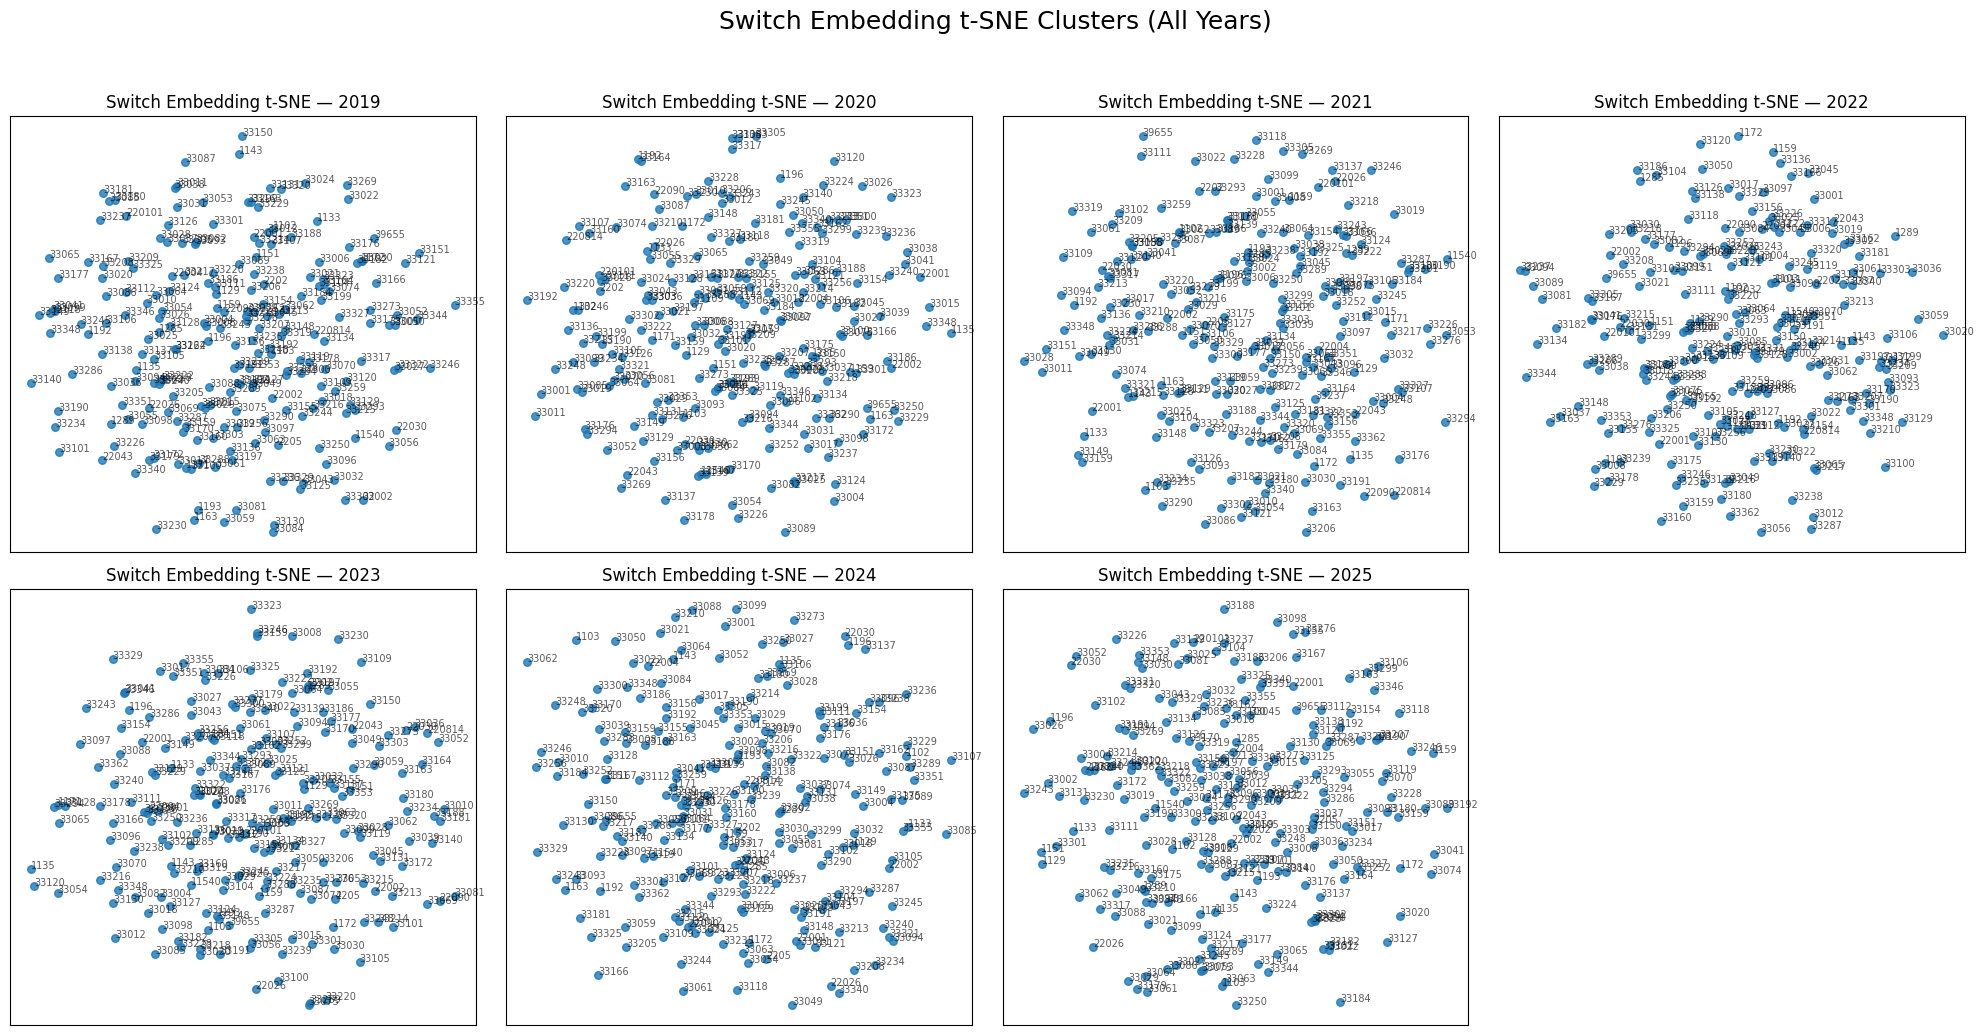

In [ ]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.manifold import TSNE  # ← use t-SNE instead of PCA

# --------------------------
# CONFIGURATION
# --------------------------
MODEL_DIR = Path("/media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/fault_model_nn_allprior_22_33kv")
FAULT_CSV = Path("/media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/DATA_GENERATION/FAULT DATA/HT_fault_cable_info_processed_without_affected.csv")
YEARS = list(range(2018, 2026))   # change if needed
EMB_DIM = 16
MIN_YEAR = 2016
MAX_YEAR = 2025
KEEP_VOLTAGES = [22, 33]

def normalize_switch_series(s: pd.Series) -> pd.Series:
    s = s.astype(str).str.upper().str.strip()
    s = s.str.replace(r"^(SWNO_|SWNO|SW|S)\s*", "", regex=True)
    s = s.str.replace(r"\D+", "", regex=True)
    return pd.to_numeric(s, errors="coerce").astype("Int64")

def v_to_num(x):
    try:
        s = str(x).lower().replace("kv","").strip()
        v = float(s);  v = v/1000.0 if v > 100 else v
        return v
    except:
        return np.nan

# --- Data load ---
fault = pd.read_csv(FAULT_CSV, low_memory=False, parse_dates=["TIME_OUTAGE"])
sw_col = None
for c in ["TO_SWITCH", "SWITCH_NO", "SWNO", "FROM_SWITCH"]:
    if c in fault.columns:
        sw_col = c; break
if sw_col is None:
    raise RuntimeError("No switch column found (TO_SWITCH / SWITCH_NO / SWNO / FROM_SWITCH).")
fault["SWITCH_ID"] = normalize_switch_series(fault[sw_col])
fault = fault.dropna(subset=["SWITCH_ID","TIME_OUTAGE"]).copy()
fault = fault[(fault["TIME_OUTAGE"].dt.year >= MIN_YEAR) & (fault["TIME_OUTAGE"].dt.year <= MAX_YEAR)].copy()
if "VOLTAGE" in fault.columns:
    fault["VNUM"] = fault["VOLTAGE"].apply(v_to_num)
    fault = fault[fault["VNUM"].isin(KEEP_VOLTAGES)].copy()
fault = fault.drop_duplicates(subset=["SWITCH_ID","TIME_OUTAGE"]).copy()
switches = sorted(fault["SWITCH_ID"].dropna().astype(int).unique())
switch_to_idx = {sw: i for i, sw in enumerate(switches)}
n_switches = len(switches)
print(f"Number of switches: {n_switches}")

# --- Model definition ---
class LSTMEncoderHead(torch.nn.Module):
    def __init__(self, n_switches, emb_dim=16, input_dim=3, hidden=128,
                 layers=2, dropout=0.1, out_horizon=12):
        super().__init__()
        self.emb = torch.nn.Embedding(num_embeddings=n_switches, embedding_dim=emb_dim)
        self.lstm = torch.nn.LSTM(input_dim, hidden, num_layers=layers,
                                  batch_first=True, dropout=dropout if layers>1 else 0.0)
        self.head = torch.nn.Sequential(
            torch.nn.Linear(hidden + emb_dim, hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden, hidden//2),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden//2, out_horizon),
        )
        self.softplus = torch.nn.Softplus()
    def forward(self, x_seq, x_season, sw_idx):
        x = torch.cat([x_seq, x_season], dim=-1)
        out, (h_n, _) = self.lstm(x)
        h_last = h_n[-1]
        e = self.emb(sw_idx)
        h = torch.cat([h_last, e], dim=1)
        raw = self.head(h)
        mu  = self.softplus(raw)
        return mu

# --------------------------
# Plot t-SNE embeddings for all years
# --------------------------
from sklearn.manifold import TSNE
import math

n_cols = 4
n_rows = math.ceil(len(YEARS)/n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*5))
axes = axes.flatten()

plotted = 0
for YEAR in YEARS:
    model_path = MODEL_DIR / f"best_Y{YEAR}.pt"
    if not model_path.exists():
        print(f"Skipping year {YEAR} (no model checkpoint found)")
        continue

    model = LSTMEncoderHead(n_switches=n_switches, emb_dim=EMB_DIM)
    model.load_state_dict(torch.load(model_path, map_location='cpu'))
    emb_weights = model.emb.weight.detach().cpu().numpy()  # [n_switches, emb_dim]

    # t-SNE to 2D (if you want deterministic results, set random_state=42)
    tsne = TSNE(n_components=2, random_state=42, perplexity=60, init='random')
    emb_2d = tsne.fit_transform(emb_weights)
    ax = axes[plotted]
    ax.scatter(emb_2d[:,0], emb_2d[:,1], alpha=0.8, s=30)
    for j, sw in enumerate(switches):
        ax.text(emb_2d[j,0], emb_2d[j,1], str(sw), fontsize=7, alpha=0.65)
    ax.set_title(f"Switch Embedding t-SNE — {YEAR}")
    ax.set_xticks([]); ax.set_yticks([])
    plotted += 1

for ax in axes[plotted:]:
    ax.axis('off')

plt.suptitle("Switch Embedding t-SNE Clusters (All Years)", fontsize=18, y=1.03)
plt.tight_layout()
plt.show()


Number of switches: 4782
Skipping year 2018 (no model checkpoint found)


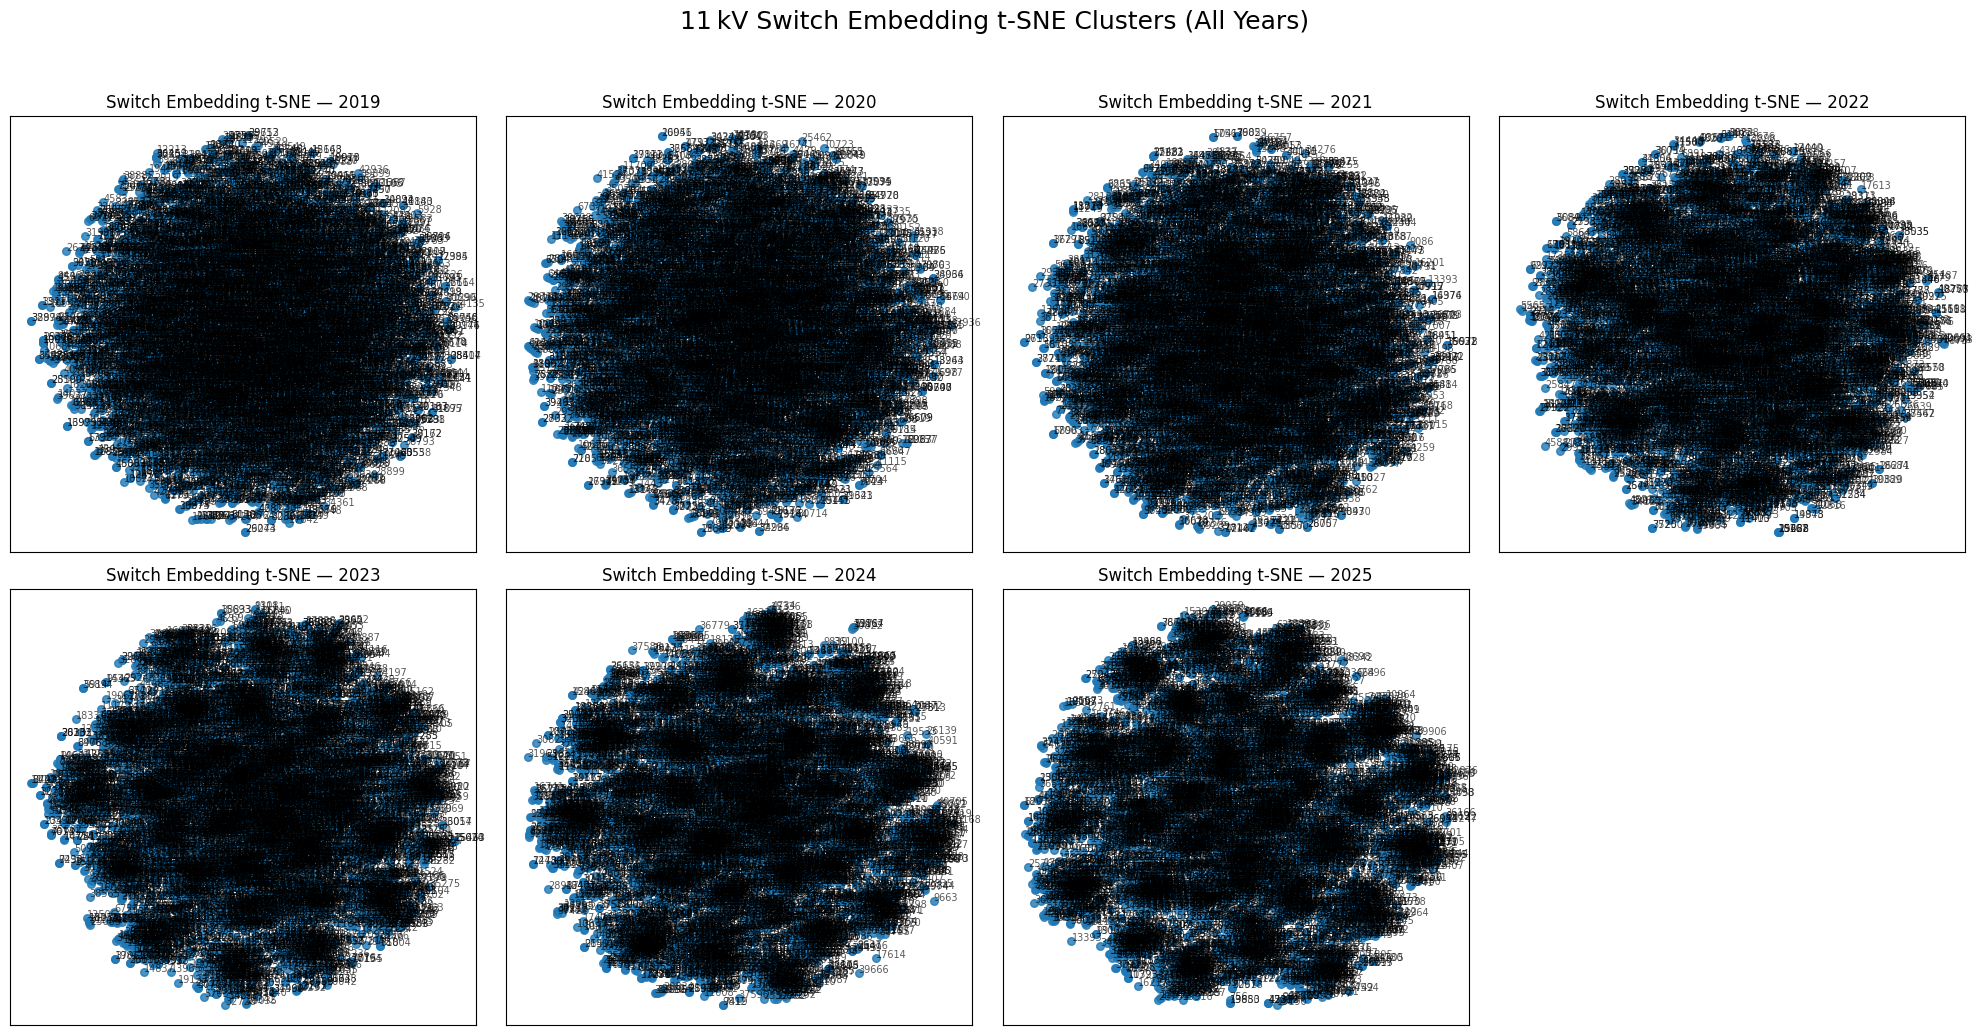

In [ ]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.manifold import TSNE  # Use t-SNE for embedding visualization

# --------------------------
# CONFIGURATION
# --------------------------
MODEL_DIR = Path("/media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/fault_model_nn_allprior_11kv")  # <-- folder for 11 kV model checkpoints!
FAULT_CSV = Path("/media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/DATA_GENERATION/FAULT DATA/HT_fault_cable_info_processed_without_affected.csv")
YEARS = list(range(2018, 2026))   # adjust if needed
EMB_DIM = 16
MIN_YEAR = 2016
MAX_YEAR = 2025
KEEP_VOLTAGES = [11]   # <--- ONLY 11 kV

# --------------------------
# Helper functions
# --------------------------
def normalize_switch_series(s: pd.Series) -> pd.Series:
    s = s.astype(str).str.upper().str.strip()
    s = s.str.replace(r"^(SWNO_|SWNO|SW|S)\s*", "", regex=True)
    s = s.str.replace(r"\D+", "", regex=True)
    return pd.to_numeric(s, errors="coerce").astype("Int64")

def v_to_num(x):
    try:
        s = str(x).lower().replace("kv","").strip()
        v = float(s);  v = v/1000.0 if v > 100 else v
        return v
    except:
        return np.nan

# --------------------------
# Load and filter fault data (as in training)
# --------------------------
fault = pd.read_csv(FAULT_CSV, low_memory=False, parse_dates=["TIME_OUTAGE"])
sw_col = None
for c in ["TO_SWITCH", "SWITCH_NO", "SWNO", "FROM_SWITCH"]:
    if c in fault.columns:
        sw_col = c; break
if sw_col is None:
    raise RuntimeError("No switch column found (TO_SWITCH / SWITCH_NO / SWNO / FROM_SWITCH).")

fault["SWITCH_ID"] = normalize_switch_series(fault[sw_col])
fault = fault.dropna(subset=["SWITCH_ID","TIME_OUTAGE"]).copy()
fault = fault[(fault["TIME_OUTAGE"].dt.year >= MIN_YEAR) & (fault["TIME_OUTAGE"].dt.year <= MAX_YEAR)].copy()
if "VOLTAGE" in fault.columns:
    fault["VNUM"] = fault["VOLTAGE"].apply(v_to_num)
    fault = fault[fault["VNUM"].isin(KEEP_VOLTAGES)].copy()
fault = fault.drop_duplicates(subset=["SWITCH_ID","TIME_OUTAGE"]).copy()

switches = sorted(fault["SWITCH_ID"].dropna().astype(int).unique())
switch_to_idx = {sw: i for i, sw in enumerate(switches)}
n_switches = len(switches)
print(f"Number of switches: {n_switches}")

# --------------------------
# Model definition (same as in training)
# --------------------------
class LSTMEncoderHead(torch.nn.Module):
    def __init__(self, n_switches, emb_dim=16, input_dim=3, hidden=128,
                 layers=2, dropout=0.1, out_horizon=12):
        super().__init__()
        self.emb = torch.nn.Embedding(num_embeddings=n_switches, embedding_dim=emb_dim)
        self.lstm = torch.nn.LSTM(input_dim, hidden, num_layers=layers,
                                  batch_first=True, dropout=dropout if layers>1 else 0.0)
        self.head = torch.nn.Sequential(
            torch.nn.Linear(hidden + emb_dim, hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden, hidden//2),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden//2, out_horizon),
        )
        self.softplus = torch.nn.Softplus()
    def forward(self, x_seq, x_season, sw_idx):
        x = torch.cat([x_seq, x_season], dim=-1)
        out, (h_n, _) = self.lstm(x)
        h_last = h_n[-1]
        e = self.emb(sw_idx)
        h = torch.cat([h_last, e], dim=1)
        raw = self.head(h)
        mu  = self.softplus(raw)
        return mu

# --------------------------
# Plot t-SNE embeddings for all years
# --------------------------
import math

n_cols = 4
n_rows = math.ceil(len(YEARS)/n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*5))
axes = axes.flatten()

plotted = 0
for YEAR in YEARS:
    model_path = MODEL_DIR / f"best_Y{YEAR}.pt"
    if not model_path.exists():
        print(f"Skipping year {YEAR} (no model checkpoint found)")
        continue

    model = LSTMEncoderHead(n_switches=n_switches, emb_dim=EMB_DIM)
    model.load_state_dict(torch.load(model_path, map_location='cpu'))
    emb_weights = model.emb.weight.detach().cpu().numpy()  # [n_switches, emb_dim]

    # t-SNE to 2D
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='random')
    emb_2d = tsne.fit_transform(emb_weights)
    ax = axes[plotted]
    ax.scatter(emb_2d[:,0], emb_2d[:,1], alpha=0.8, s=30)
    for j, sw in enumerate(switches):
        ax.text(emb_2d[j,0], emb_2d[j,1], str(sw), fontsize=7, alpha=0.65)
    ax.set_title(f"Switch Embedding t-SNE — {YEAR}")
    ax.set_xticks([]); ax.set_yticks([])
    plotted += 1

for ax in axes[plotted:]:
    ax.axis('off')

plt.suptitle("11 kV Switch Embedding t-SNE Clusters (All Years)", fontsize=18, y=1.03)
plt.tight_layout()
plt.show()
